In [134]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
from gym import wrappers

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
# import random
import time

import seaborn as sns
import matplotlib.pyplot as plt

def run_episode(env, policy, gamma, render = False):
    """ Runs an episode and return the total reward """
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        obs, reward, done , _ = env.step(int(policy[obs]))
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

def evaluate_policy(env, policy, gamma, n):
    scores = [run_episode(env, policy, gamma, False) for _ in range(n)]
    return scores

def extract_policy(v, gamma ):
    """ Extract the policy given a value-function """
    policy = np.zeros(num_states)
    for s in range(num_states):
        q_sa = np.zeros(num_actions)
        for a in range(num_actions):
            for p, s_, r, _ in env.P[s][a]:
                # next_sr(p, s_, r, _) is a tuple of (probability, next state, reward, done)
                q_sa[a] += (p * (r + gamma * v[s_]))
        policy[s] = np.argmax(q_sa)
    return policy

def compute_policy_v(env, policy, gamma):
    """ Iteratively evaluate the value-function under policy.
    Alternatively, we could formulate a set of linear equations in iterms of v[s] 
    and solve them to find the value function.
    """
    v = np.zeros(env.observation_space.n)
    eps = 1e-20
    #eps=0.1
    while True:
        prev_v = np.copy(v)
        for s in range(env.observation_space.n):
            policy_a = policy[s]
            v[s] = sum([p * (r + gamma * prev_v[s_]) for p, s_, r, _ in env.P[s][policy_a]])
        if (np.sum((np.fabs(prev_v - v))) <= eps):
            # value converged
            break
    return v

def policy_iteration(env, gamma, max_iterations):
    """ Policy-Iteration algorithm """
    
    policy = np.random.choice(env.action_space.n, size=(env.observation_space.n))  # initialize a random policy
    # max_iterations = 3000
    # gamma = 1.0
    # delta_list = []
    for i in range(max_iterations):
        # delta = 0
        old_policy_v = compute_policy_v(env, policy, gamma)
        new_policy = extract_policy(old_policy_v, gamma)
        if (np.all(policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        policy = new_policy
    return policy

In [245]:
# https://towardsdatascience.com/this-is-how-reinforcement-learning-works-5080b3a335d6
# function for displaying a heatmap
def display_policy(P, env):
    nb_states = env.observation_space.n
    visited_states = np.zeros(nb_states).astype(bool)
    visited_states[0] = 1
    states_labels = np.where(P==0, '<', 
                              np.where(P==1, 'v', 
                                       np.where(P==2, '>', 
                                                np.where(P==3, '^', P)
                                               )
                                      )
                             ) 
    desc = env.unwrapped.desc.ravel().astype(str)
    colors = np.where(desc=='S','y',np.where(desc=='F','b',np.where(desc=='H','r',np.where(desc=='G','g',desc))))
    states_labels = np.zeros(nb_states).astype(str)
    states_labels[:] = ''
    total_reward = 0
    s = env.reset()
    #env.render()
    done = False
    while done != True: 
        best_a = P[s] # select the best next action from the policy
        states_labels[s] = '^' if best_a==0 else ('>' if best_a==1 else ('v' if best_a==2 else '<'))   
        #print(s, best_a)
        s, rew, done, info = env.step(best_a) #take step using selected action
        total_reward = total_reward + rew
        visited_states[s] = 1 # mark the state as visited
        #env.render()
    x = np.where(desc=='S',2,np.where(desc=='F',1,np.where(desc=='H',4,np.where(desc=='G',3,desc)))).astype(int)
    ax = sns.heatmap(x.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                 linewidth=0.5, 
                 annot=states_labels.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))), 
                #  cmap=list(colors),
                cmap ="Reds",
                 fmt = '',
                 cbar=False)
    plt.show()
    print("Total Reward: ", total_reward)

In [195]:
states_labels.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states)))

array([['>', 'v', '^', ''],
       ['', '>', '^', ''],
       ['', '>', '>', '>'],
       ['', '', '', '']], dtype='<U32')

In [249]:
optimal_policy

array([0., 0., 0., 2., 0., 0., 1., 2., 1., 1., 1., 1., 1., 2., 2., 0.])

In [255]:
d = np.where(P==0, '<', np.where(P==1, 'v', np.where(P==2, '>', np.where(P==3, '^', P))))

d.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))).astype(str)

array([['<', '<', '<', '>'],
       ['<', '<', 'v', '>'],
       ['v', 'v', 'v', 'v'],
       ['v', '>', '>', '<']], dtype='<U32')

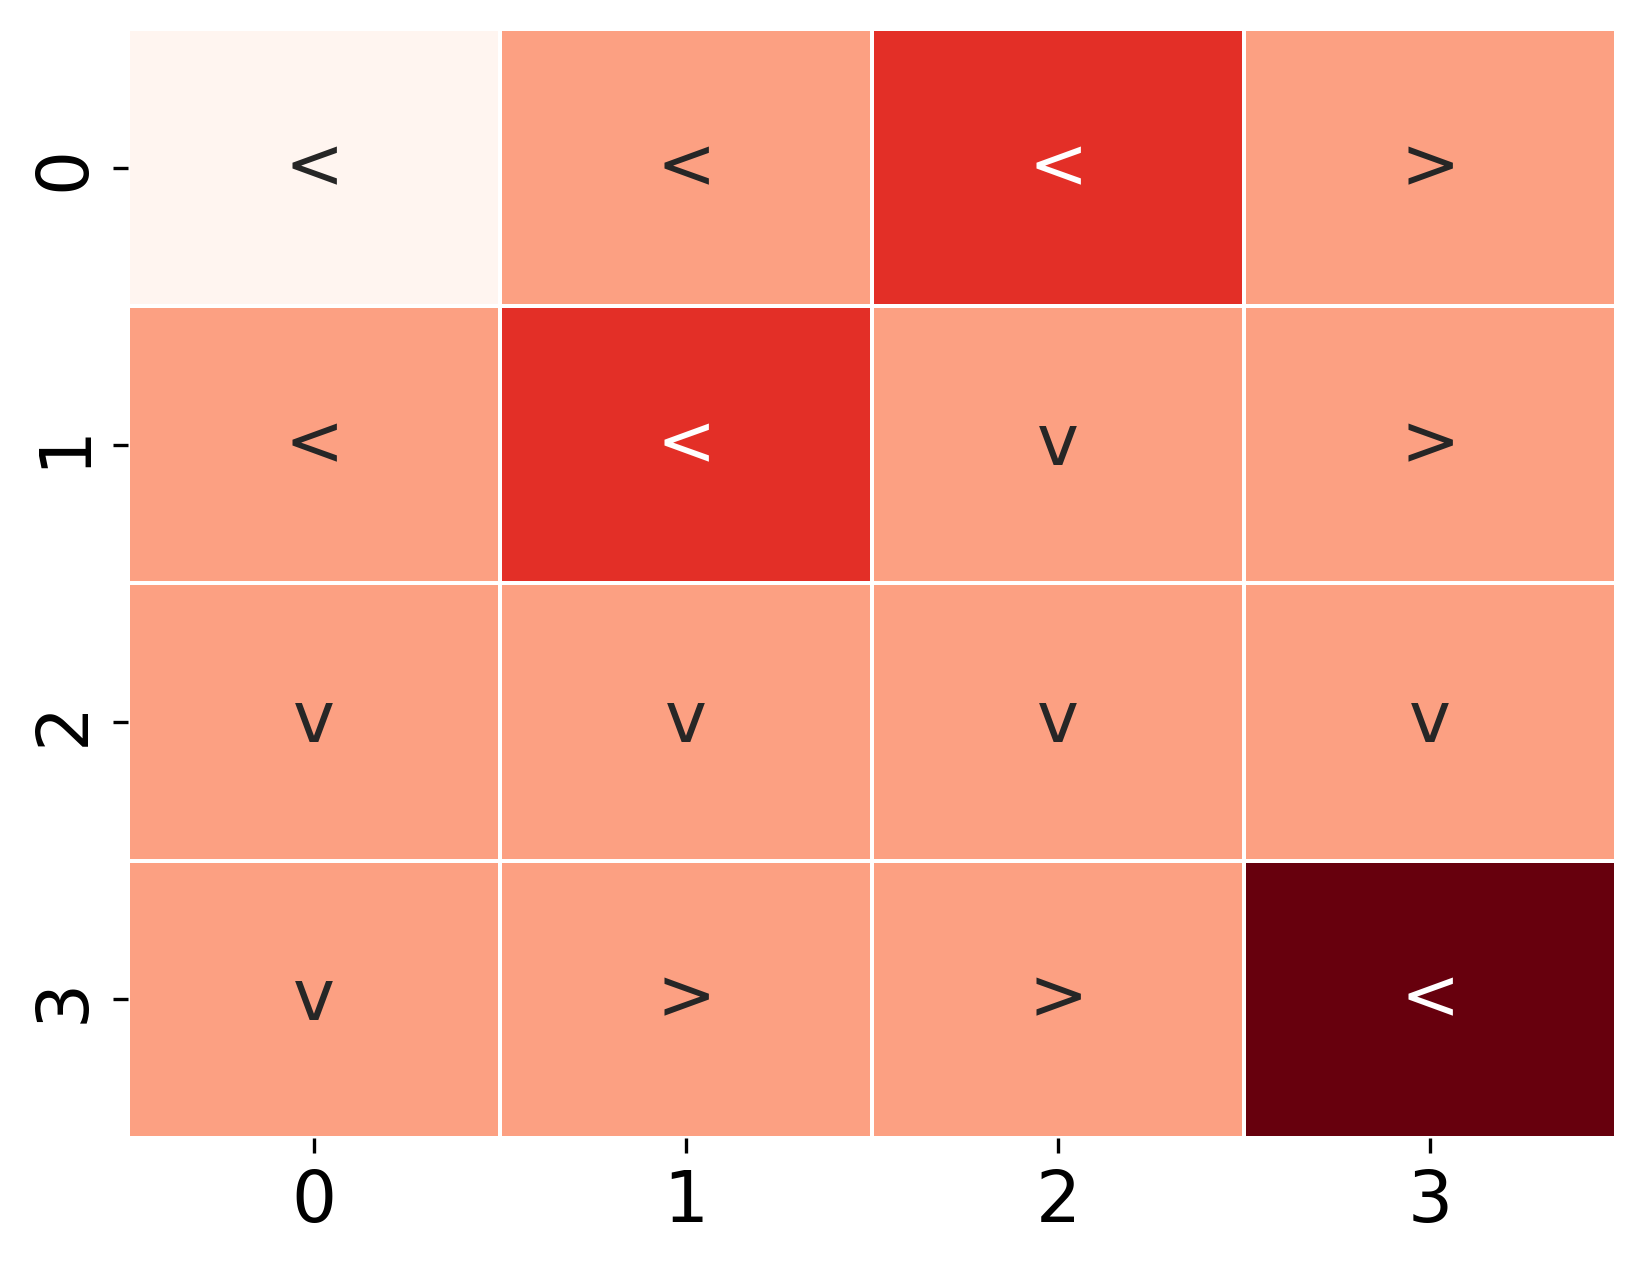

Total Reward:  1.0


In [256]:
visited_states = np.zeros(nb_states).astype(bool)
visited_states[0] = 1
P = optimal_policy
desc = env.unwrapped.desc.ravel().astype(str)

nb_states = env.observation_space.n
visited_states = np.zeros(nb_states).astype(bool)
visited_states[0] = 1
states_labels = np.where(P==0, '<', 
                          np.where(P==1, 'v', 
                                    np.where(P==2, '>', 
                                            np.where(P==3, '^', P)
                                            )
                                  )
                          ) 
desc = env.unwrapped.desc.ravel().astype(str)
colors = np.where(desc=='S','y',np.where(desc=='F','b',np.where(desc=='H','r',np.where(desc=='G','g',desc))))
states_labels = np.zeros(nb_states).astype(str)
states_labels[:] = ''
total_reward = 0
s = env.reset()
#env.render()
done = False
while done != True: 
    best_a = P[s] # select the best next action from the policy
    states_labels[s] = '^' if best_a==0 else ('>' if best_a==1 else ('v' if best_a==2 else '<'))   
    #print(s, best_a)
    s, rew, done, info = env.step(best_a) #take step using selected action
    total_reward = total_reward + rew
    visited_states[s] = 1 # mark the state as visited
    #env.render()
x = np.where(desc=='S',1,np.where(desc=='F',2,np.where(desc=='H',3,np.where(desc=='G',4,desc)))).astype(int)
d = np.where(P==0, '<', np.where(P==1, 'v', np.where(P==2, '>', np.where(P==3, '^', P))))

ax = sns.heatmap(x.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))).astype(int), 
              linewidth=0.5, 
              annot=d.reshape(int(np.sqrt(nb_states)),int(np.sqrt(nb_states))).astype(str), 
              cmap="Reds",
              fmt = '',
              cbar=False)
plt.show()
print("Total Reward: ", total_reward)

In [149]:
desc = env.unwrapped.desc.ravel().astype(str)
np.where(desc=='S','r',np.where(desc=='F','b',np.where(desc=='H','r',np.where(desc=='G','g',desc))))

array(['r', 'b', 'b', 'b', 'b', 'b', 'b', 'r', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'g'], dtype='<U1')

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `FrozenLake-v1` instead of the unversioned environment `FrozenLake`.
  logger.warn(


gamma = 0.01
Policy-Iteration converged at step 3.


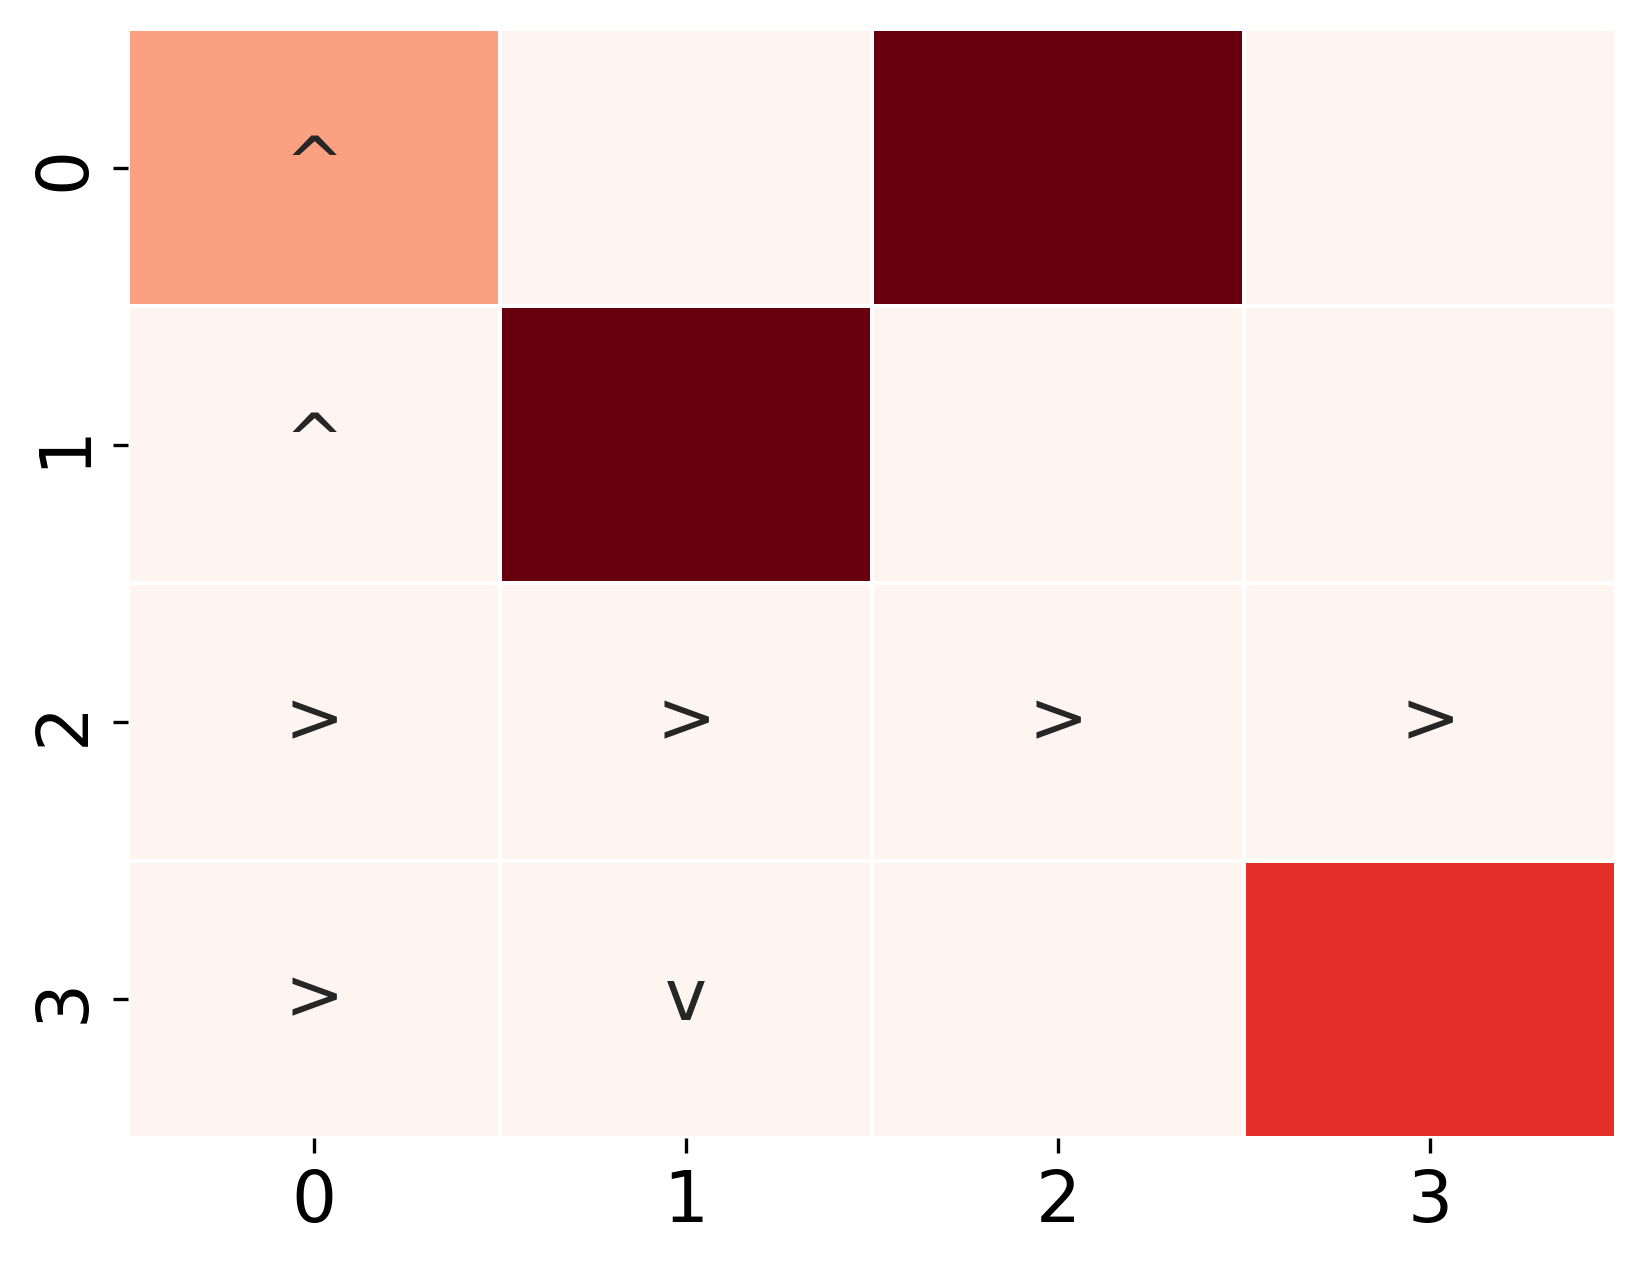

Total Reward:  1.0


<ipython-input-246-17a3ef6b7697>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(perf)


gamma = 0.5
Policy-Iteration converged at step 3.


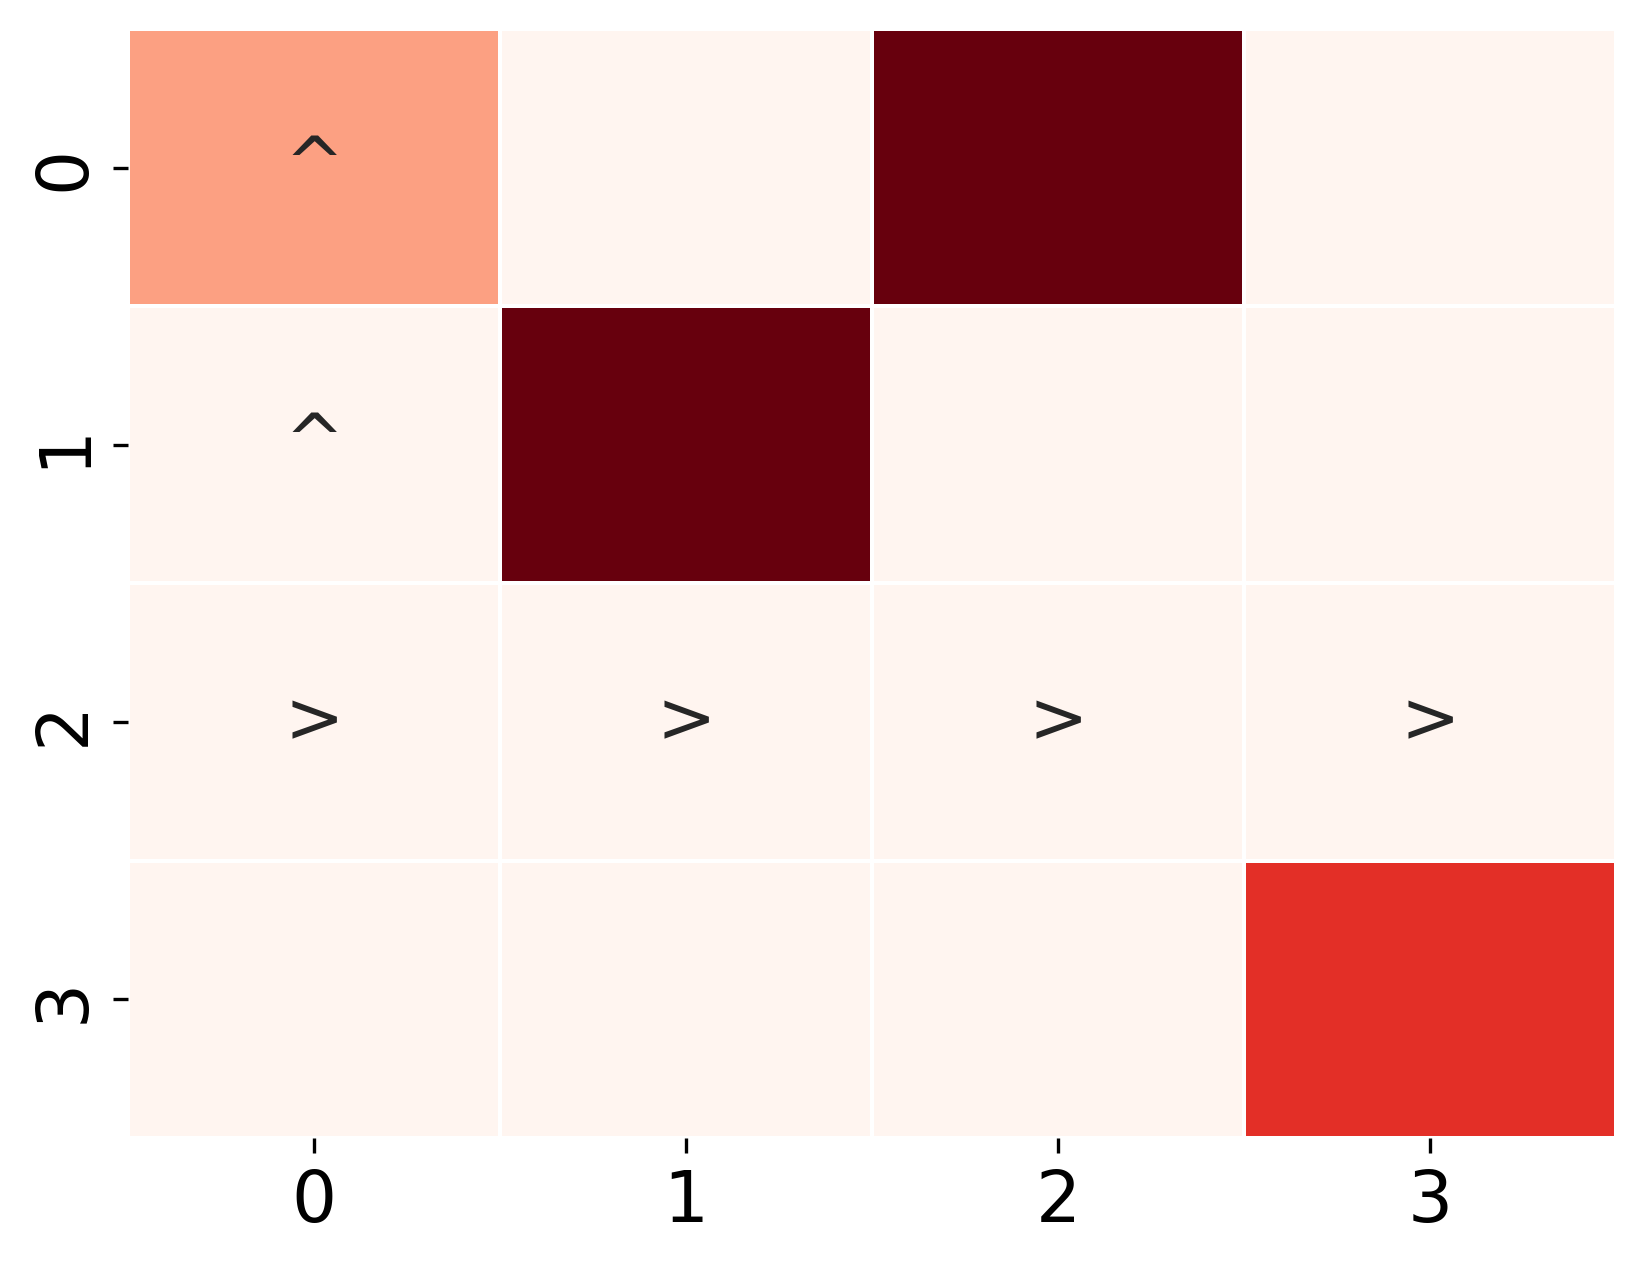

Total Reward:  1.0


<ipython-input-246-17a3ef6b7697>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(perf)


gamma = 0.9
Policy-Iteration converged at step 4.


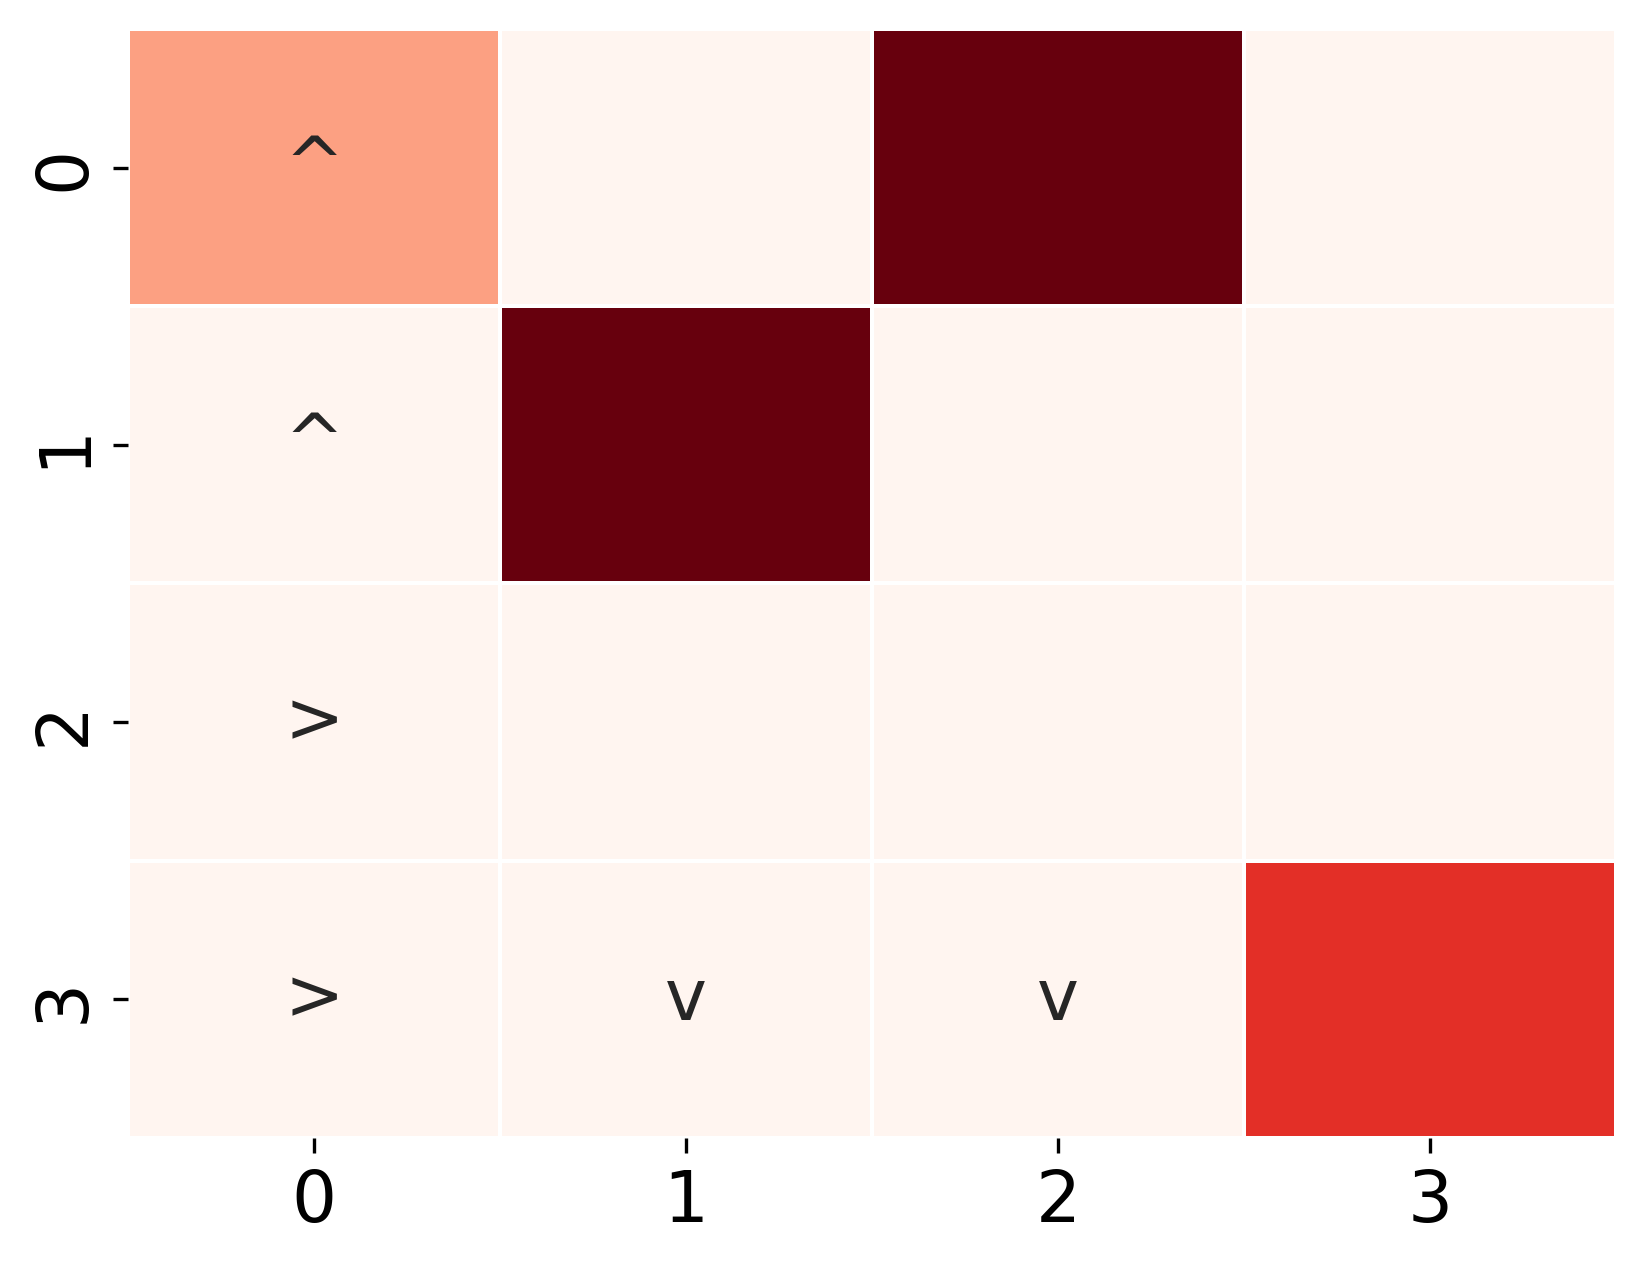

Total Reward:  1.0
   gamma  policy_score   time
0   0.01       0.00000  1.342
0   0.50       0.00074  1.235
0   0.90       0.15264  1.304


<ipython-input-246-17a3ef6b7697>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(perf)


In [246]:
random_map = generate_random_map(size=4, p=0.8)
env_name  = 'FrozenLake'
env = gym.make(env_name, desc=random_map)
num_states = env.observation_space.n
num_actions = env.action_space.n
output = pd.DataFrame()
for gamma in [0.01, 0.5, 0.9]:
  print("gamma = " + str(gamma))
  start = time.time()
  max_iterations = 10000

  optimal_policy = policy_iteration(env, gamma = gamma, max_iterations=max_iterations)
  display_policy(optimal_policy, env = env)

  policy_score = evaluate_policy(env, optimal_policy, gamma = gamma, n=1000)
  end = time.time() - start
  # print(policy_score)
  perf = pd.DataFrame({
      'gamma':[gamma],
      # 'len(optiv)':[len(optimal_v)],
      # 'ps': [policy_scores],
      'policy_score':[np.round(np.mean(policy_score),5)],
      'time':[np.round(end,3)],
      #  'vi': [val]
  })
  output = output.append(perf)
print(output)

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `FrozenLake-v1` instead of the unversioned environment `FrozenLake`.
  logger.warn(


gamma = 0.01
Policy-Iteration converged at step 6.


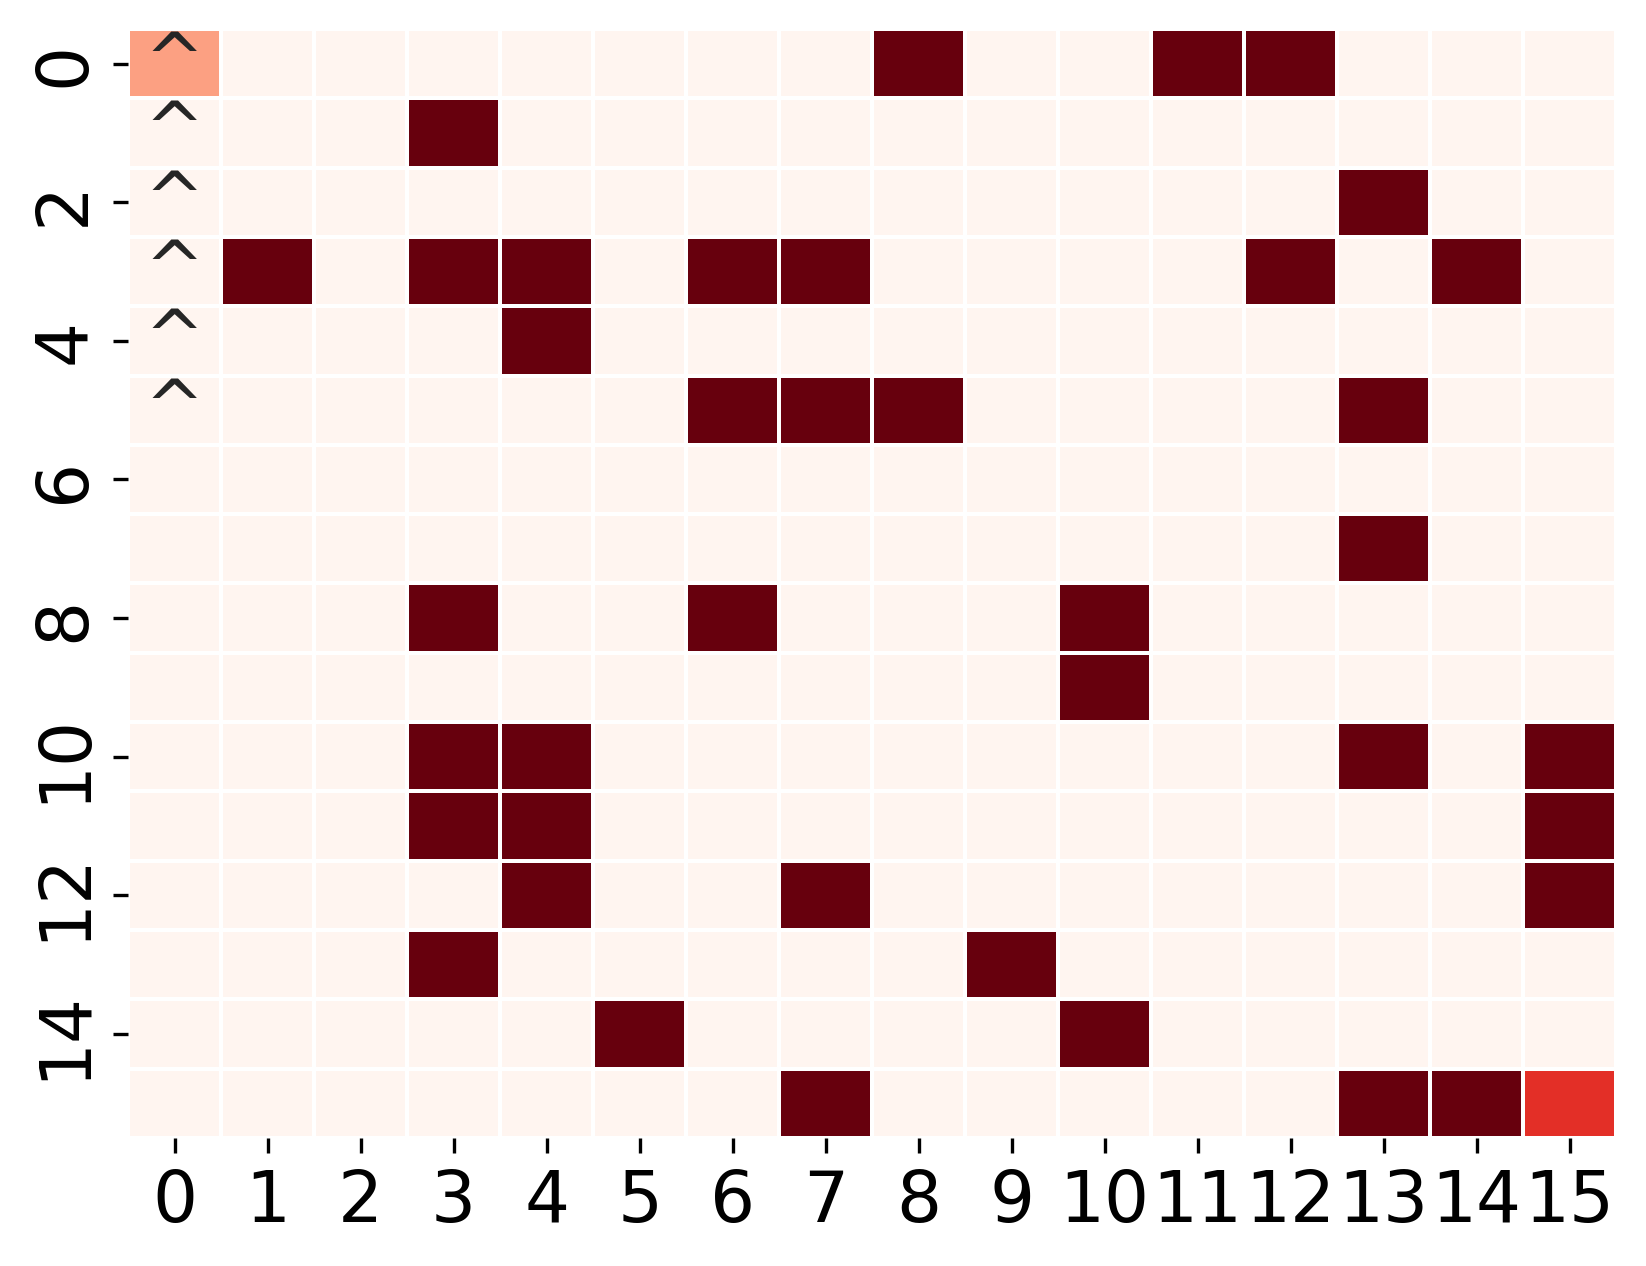

Total Reward:  0.0


<ipython-input-257-5ccef47f3da5>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(perf)


gamma = 0.5
Policy-Iteration converged at step 18.


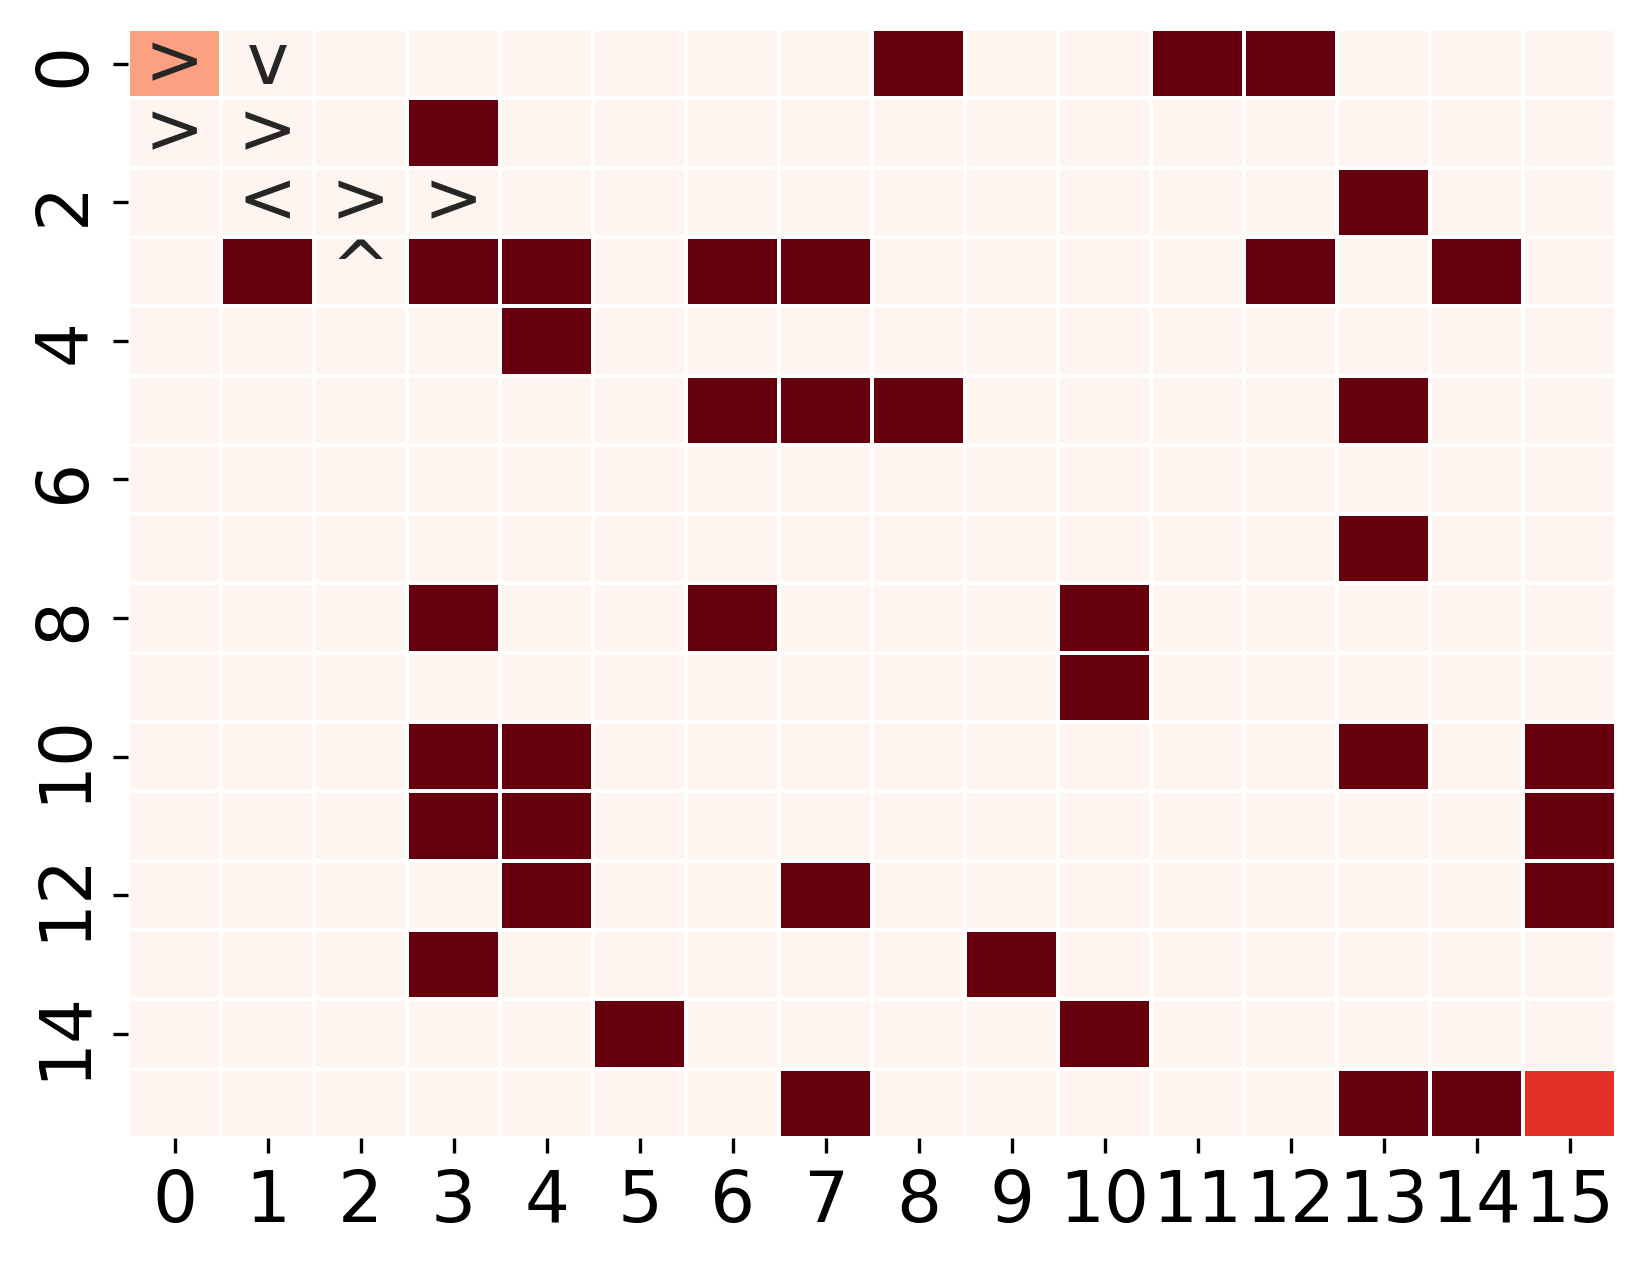

Total Reward:  0.0


<ipython-input-257-5ccef47f3da5>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = output.append(perf)


gamma = 0.9


KeyboardInterrupt: ignored

In [257]:
random_map = generate_random_map(size=16, p=0.8)
env_name  = 'FrozenLake'
env = gym.make(env_name, desc=random_map)
num_states = env.observation_space.n
num_actions = env.action_space.n
output = pd.DataFrame()
for gamma in [0.01, 0.5, 0.9]:
  print("gamma = " + str(gamma))
  start = time.time()
  max_iterations = 5000

  optimal_policy = policy_iteration(env, gamma = gamma, max_iterations=max_iterations)
  display_policy(optimal_policy, env = env)

  policy_score = evaluate_policy(env, optimal_policy, gamma = gamma, n=1000)
  end = time.time() - start
  # print(policy_score)
  perf = pd.DataFrame({
      'gamma':[gamma],
      # 'len(optiv)':[len(optimal_v)],
      # 'ps': [policy_scores],
      'policy_score':[np.round(np.mean(policy_score),5)],
      'time':[np.round(end,3)],
      #  'vi': [val]
  })
  output = output.append(perf)
print(output)

# Q learning


In [92]:
def eval(environment, qtable):
  episodes = 100
  nb_success = 0

  # Evaluation
  for _ in range(100):
      state = environment.reset()
      done = False
      
      # Until the agent gets stuck or reaches the goal, keep training it
      while not done:
          # Choose the action with the highest value in the current state
          if np.max(qtable[state]) > 0:
            action = np.argmax(qtable[state])

          # If there's no best action (only zeros), take a random one
          else:
            action = environment.action_space.sample()
              
          # Implement this action and move the agent in the desired direction
          new_state, reward, done, info = environment.step(action)

          # Update our current state
          state = new_state

          # When we get a reward, it means we solved the game
          nb_success += reward

  # Let's check our success rate!
  print (f"Success rate = {nb_success/episodes*100}%")

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `FrozenLake-v1` instead of the unversioned environment `FrozenLake`.
  logger.warn(
<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


time: 0.155
alpha:  0.01 gamma:  0.01
reward 497.0
Success rate = 100.0%


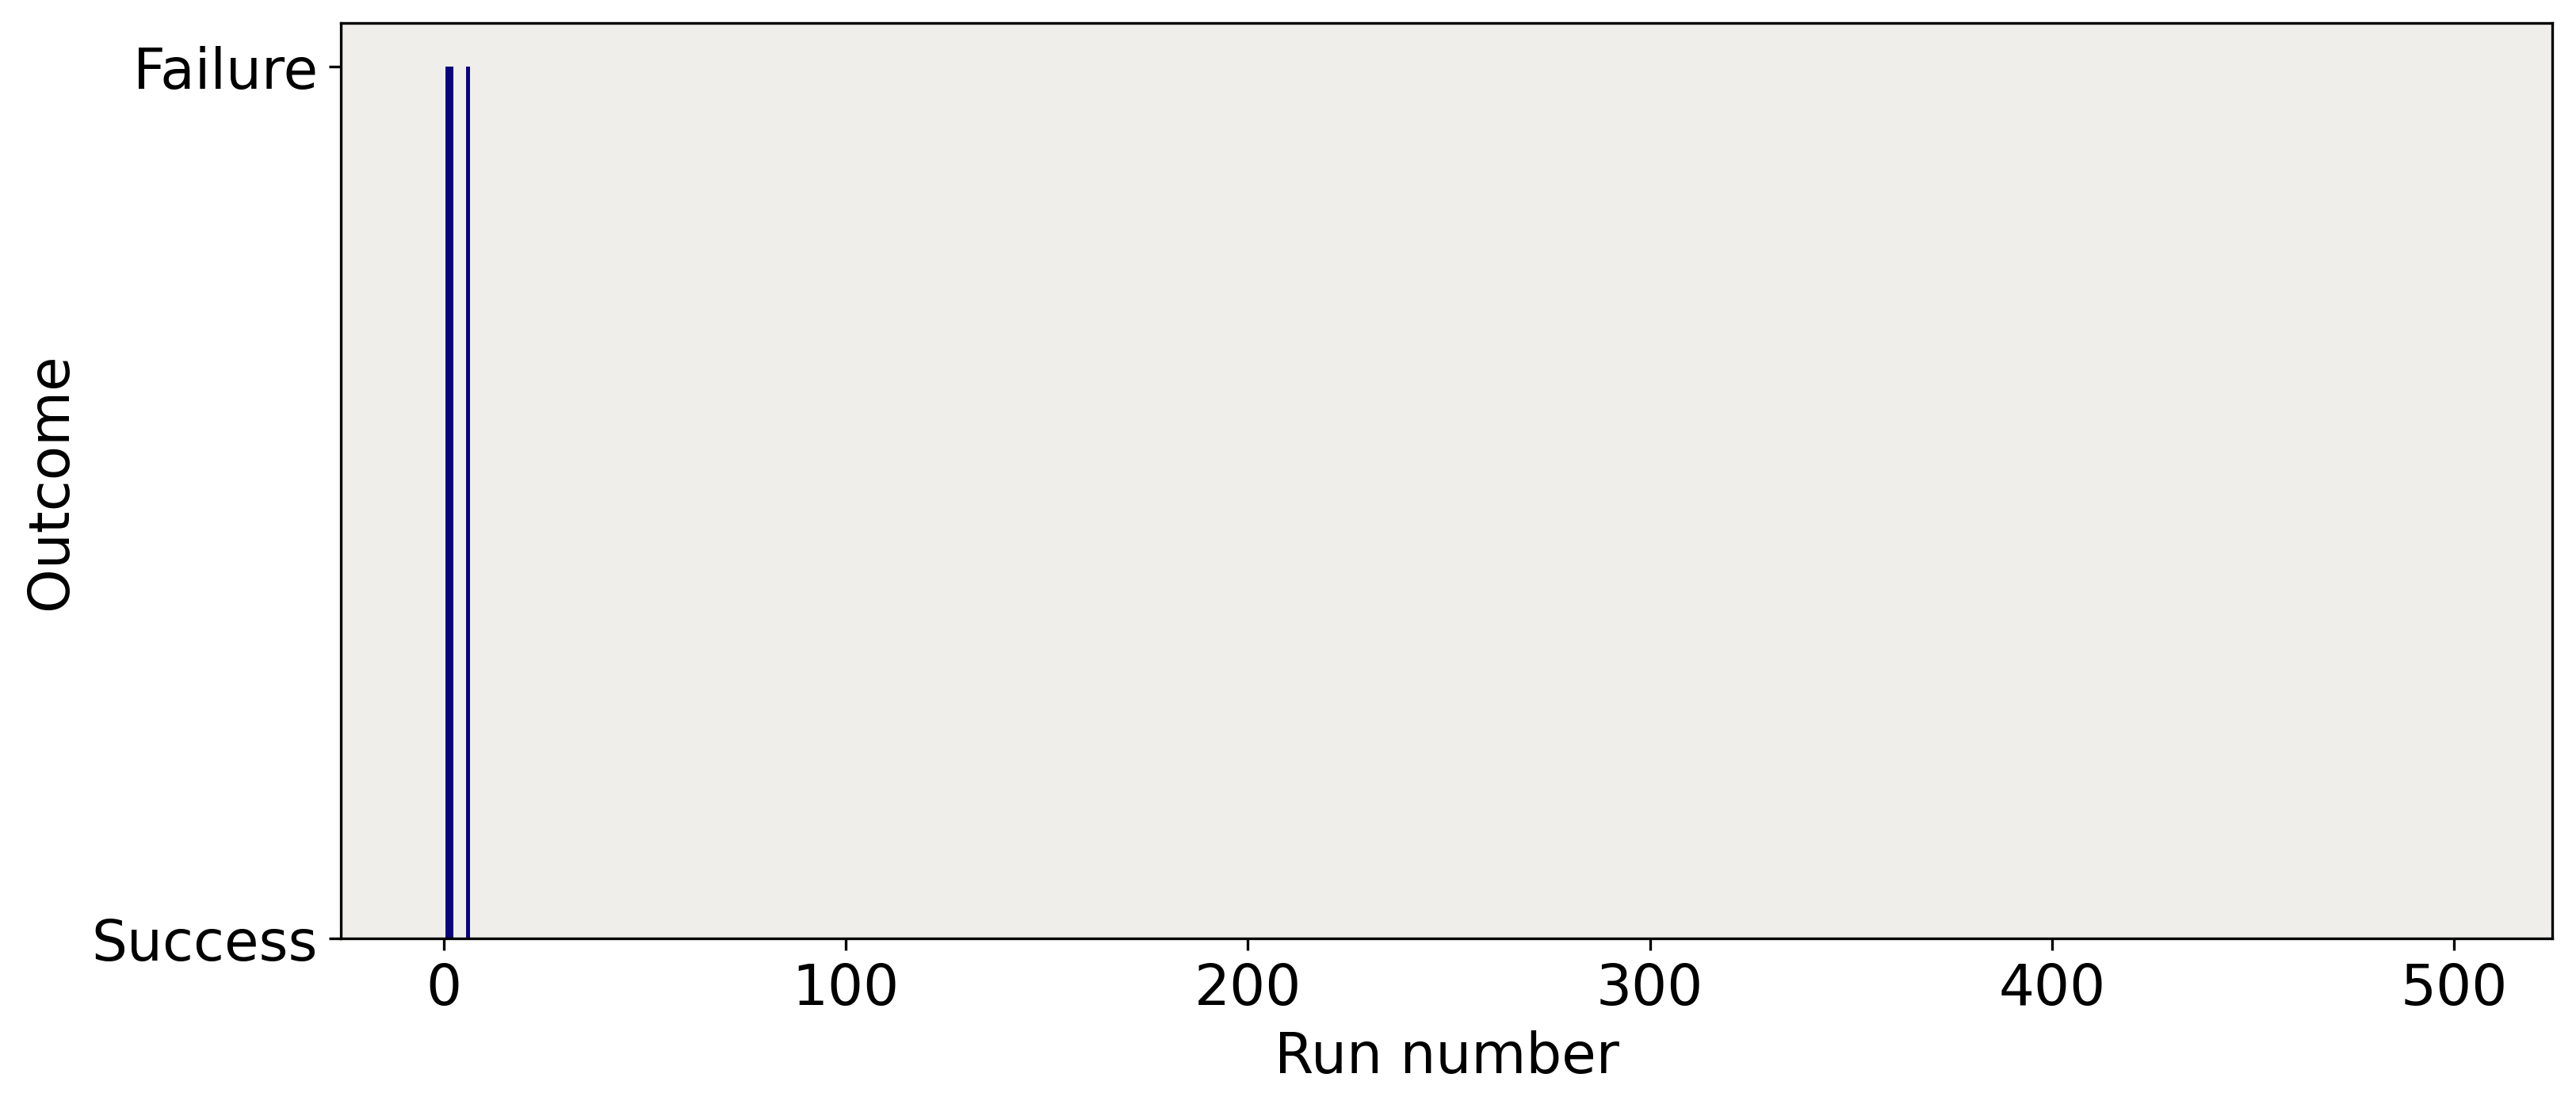

time: 0.23
alpha:  0.01 gamma:  0.5
reward 490.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


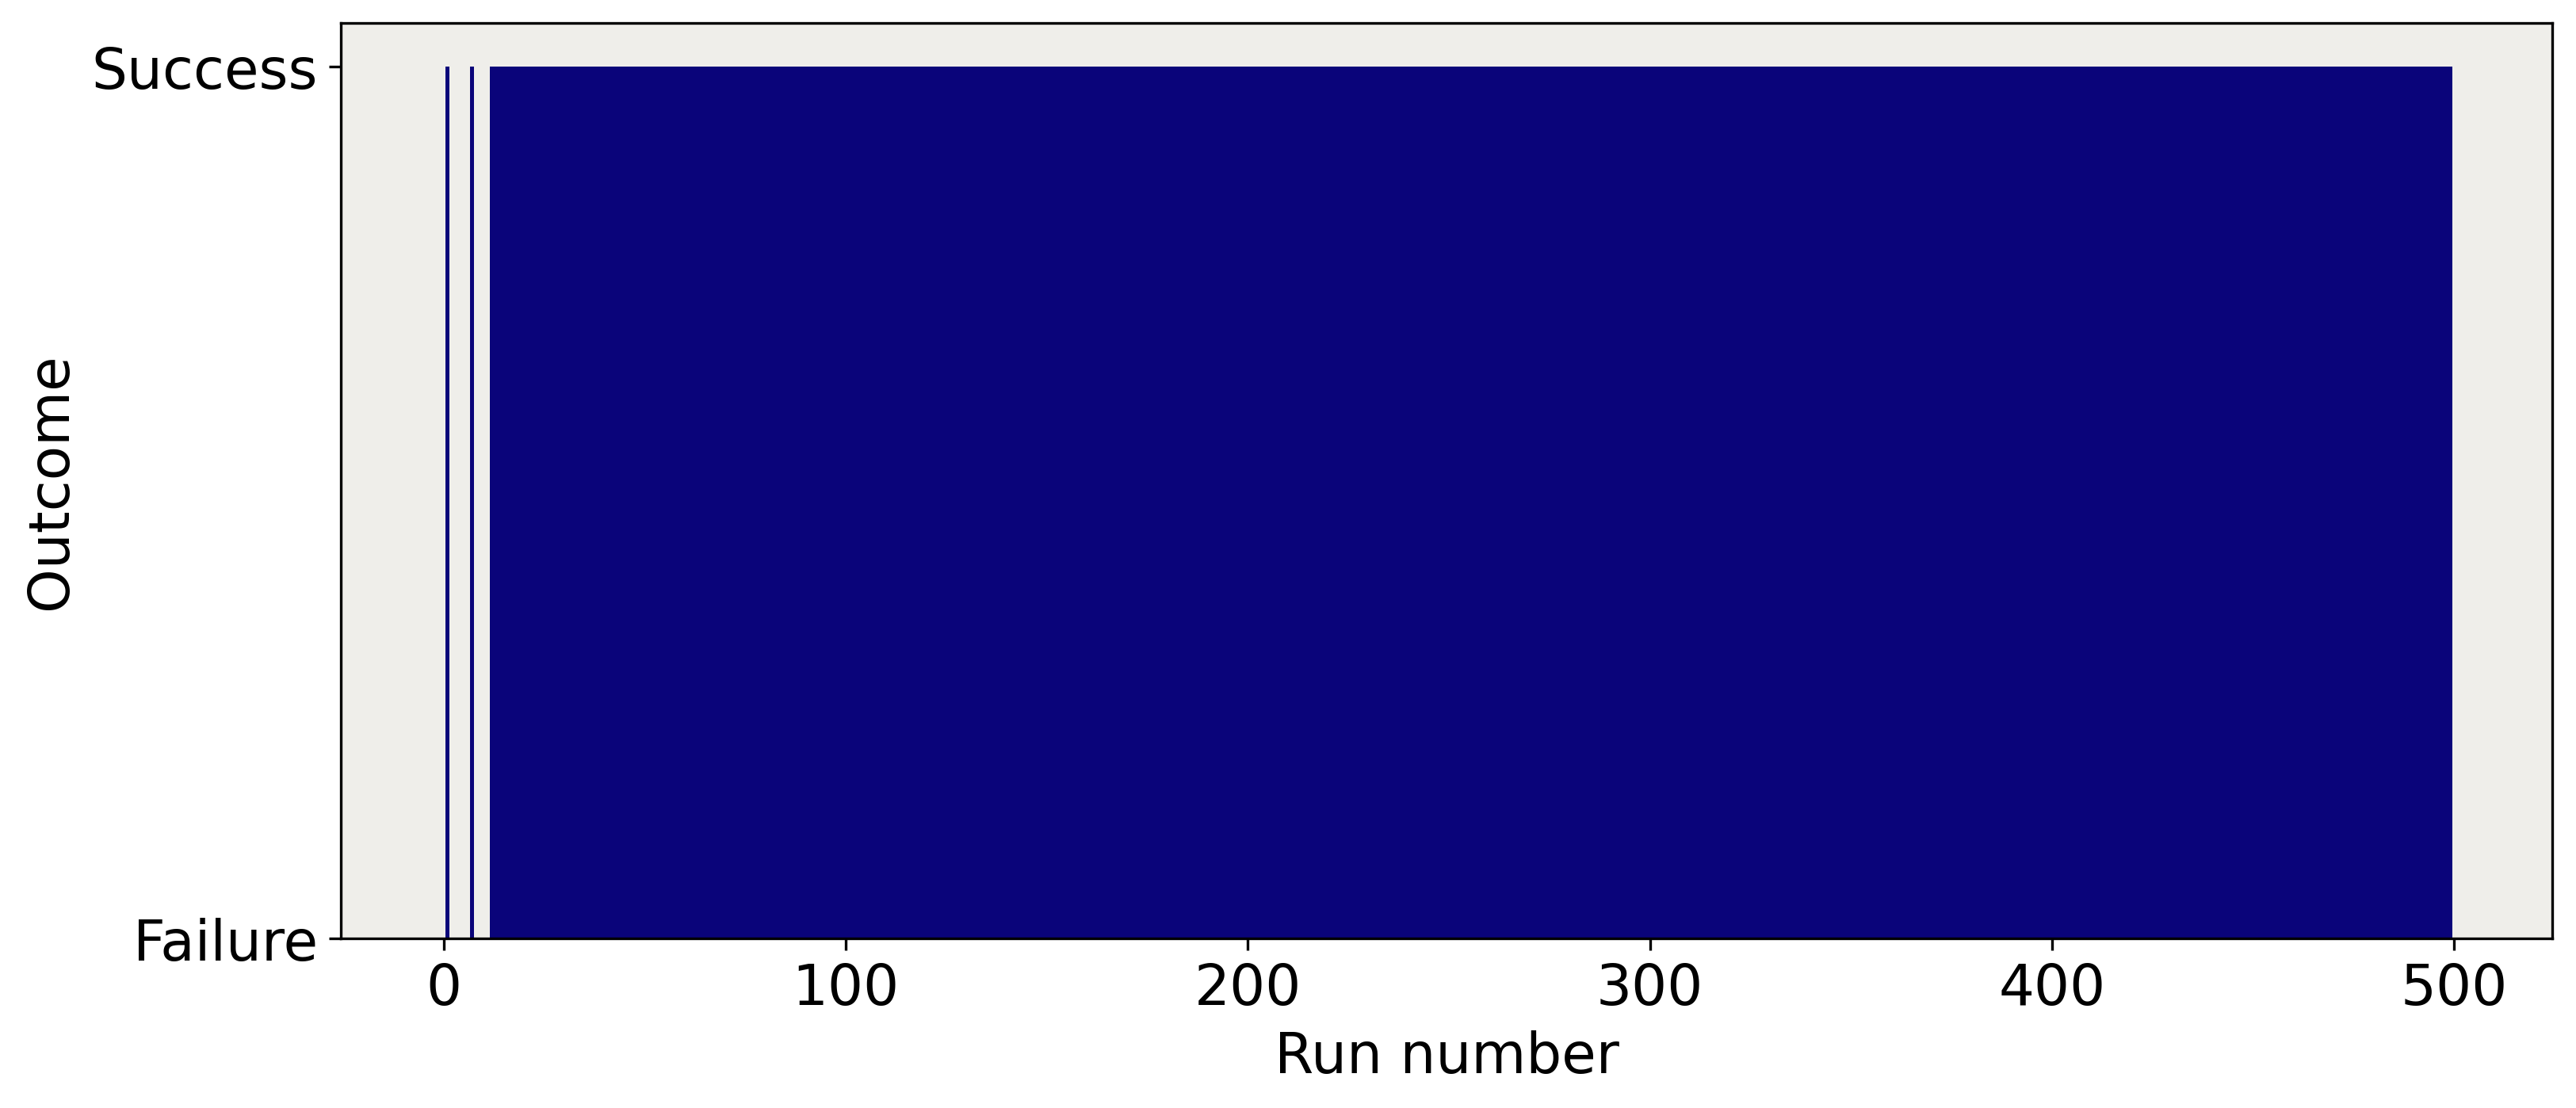

time: 0.206
alpha:  0.01 gamma:  0.9
reward 497.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


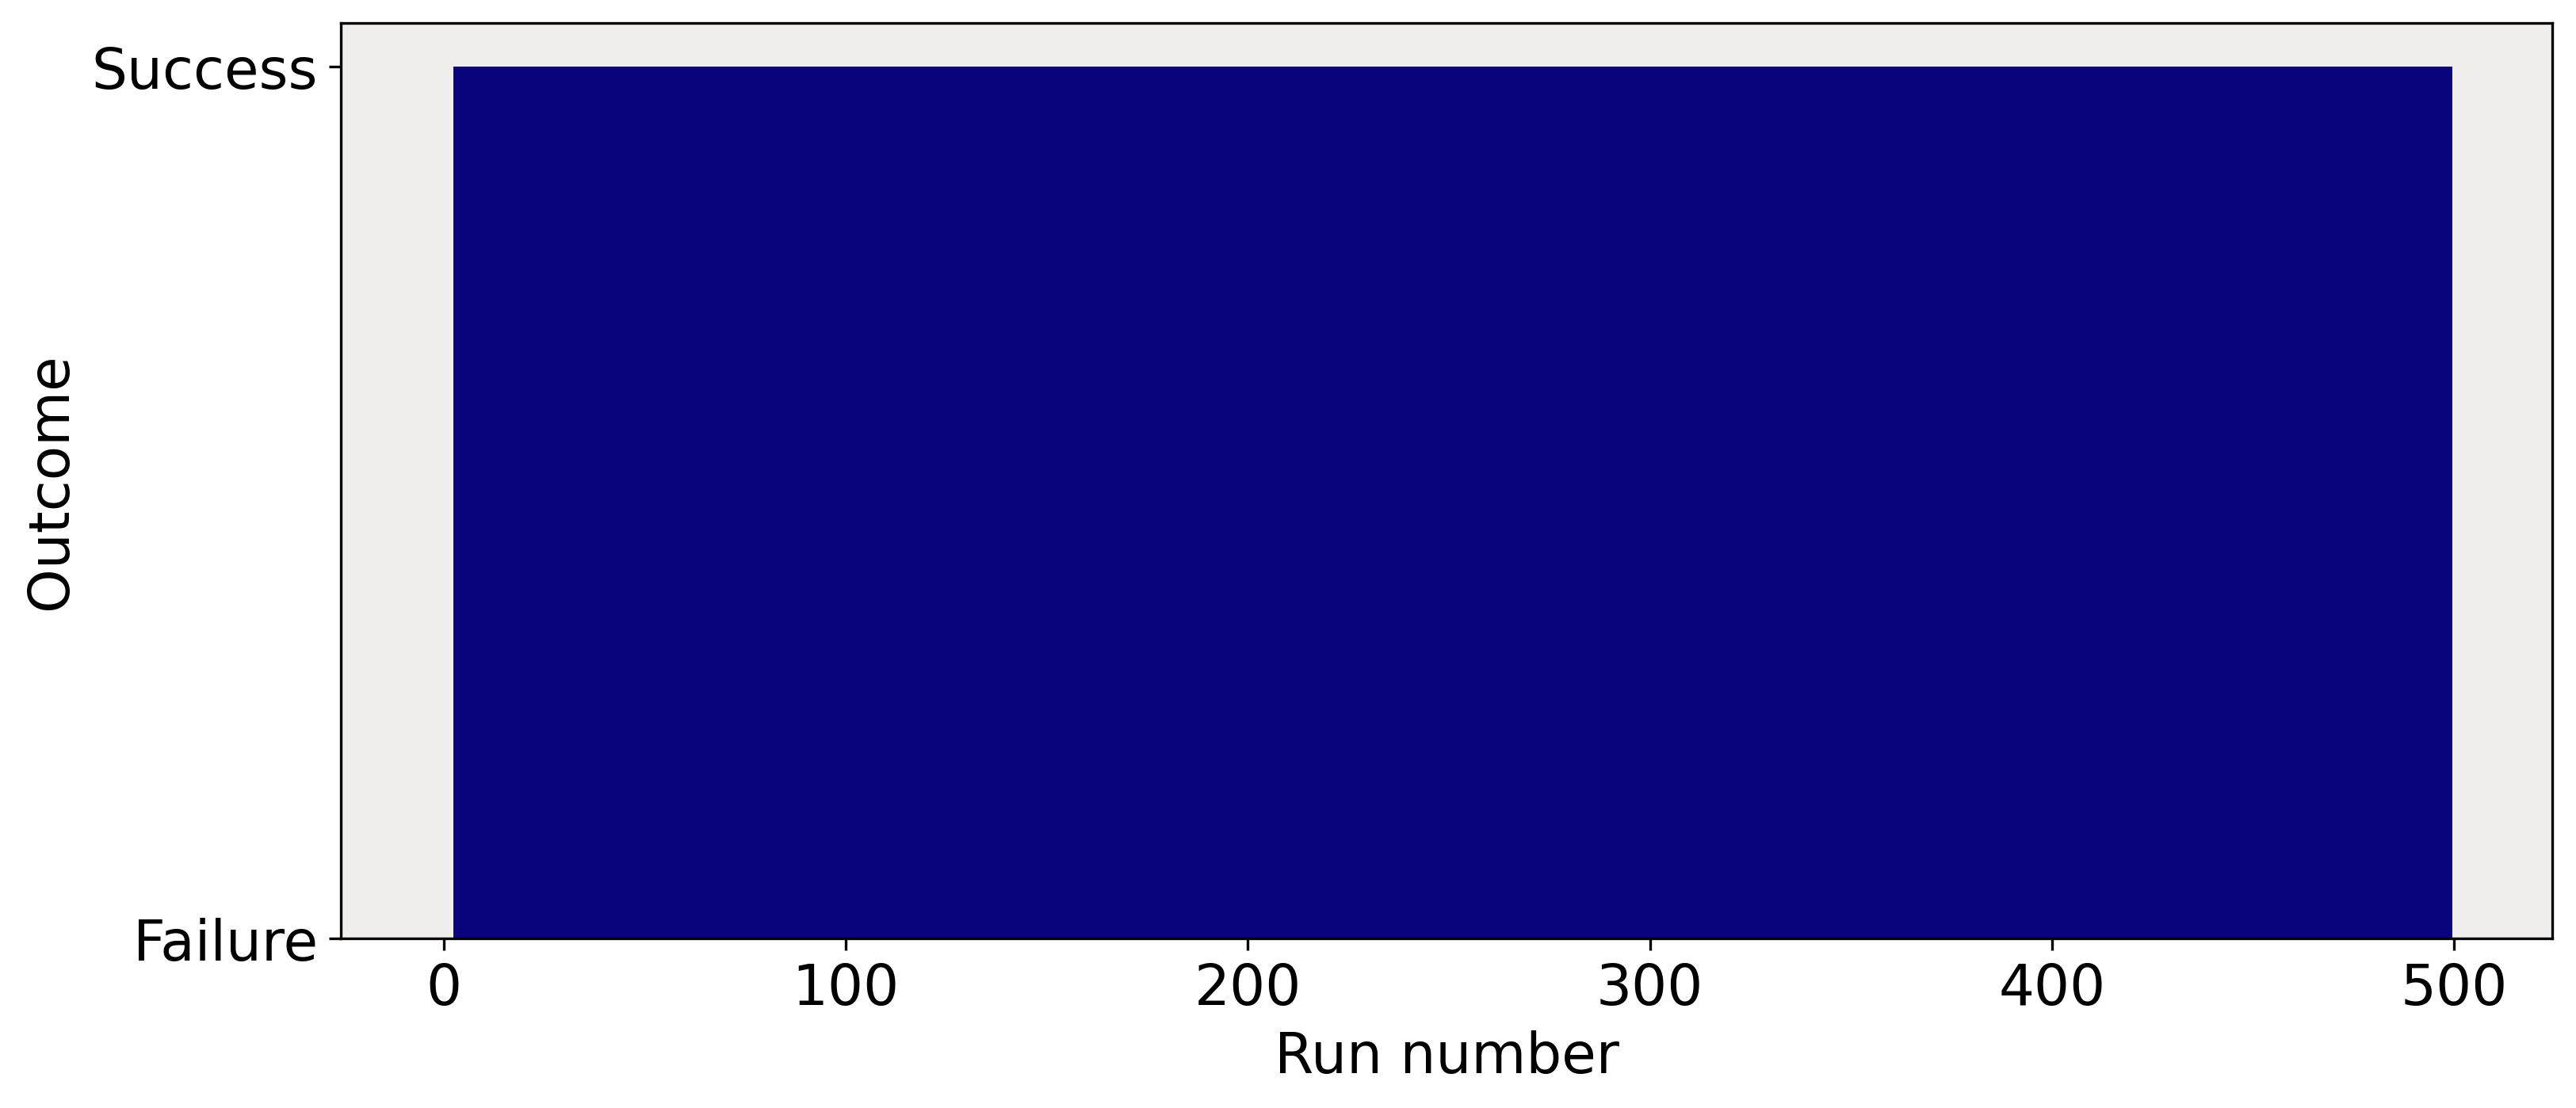

time: 0.183
alpha:  0.5 gamma:  0.01
reward 492.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


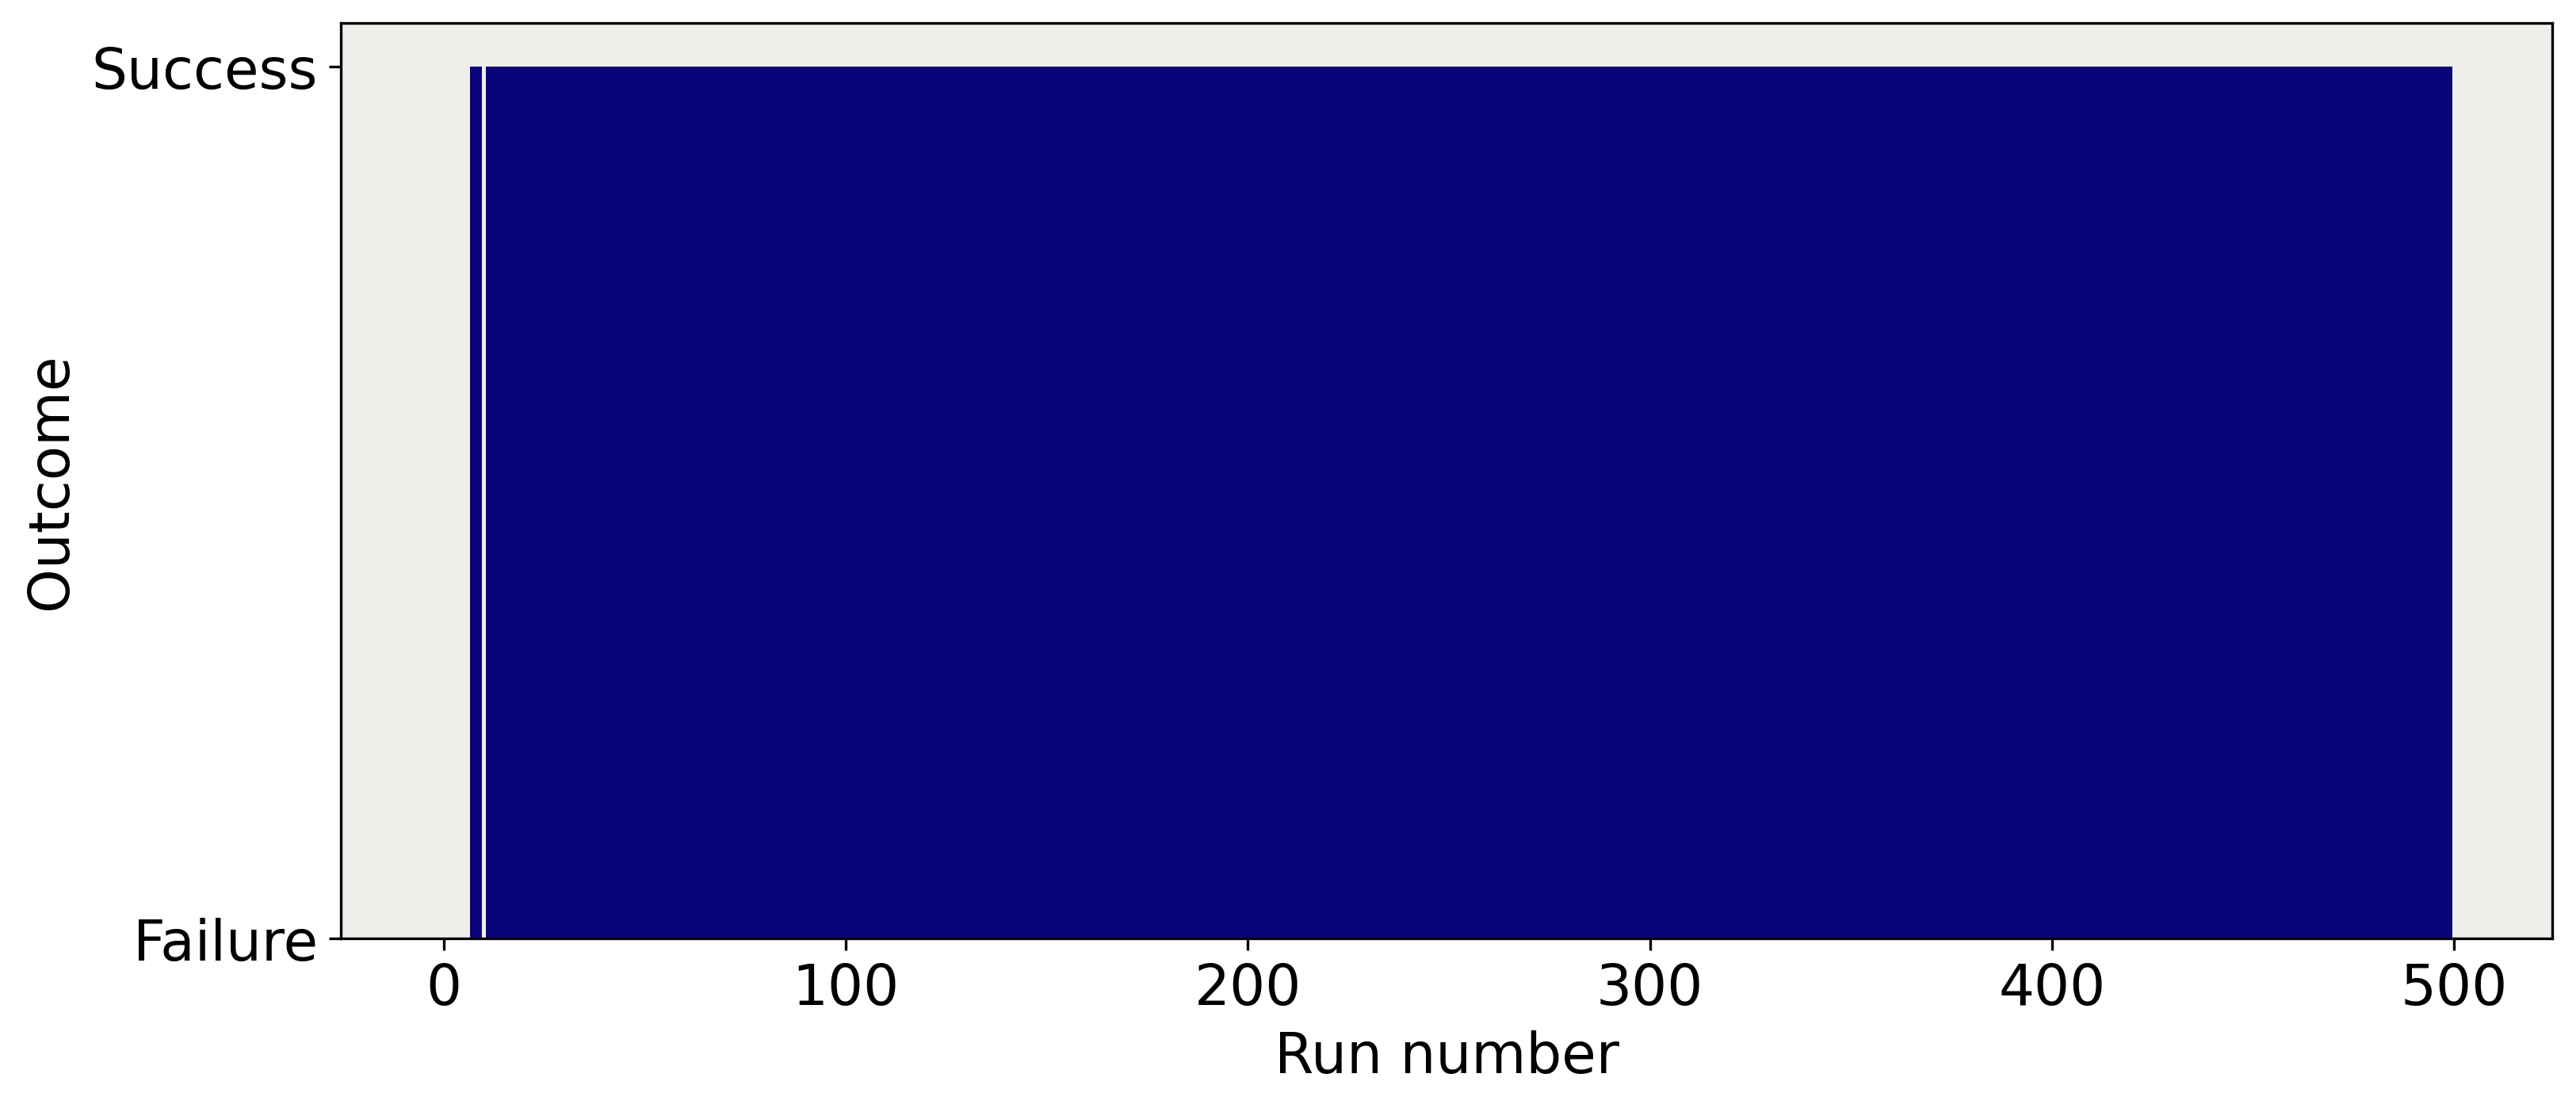

time: 0.188
alpha:  0.5 gamma:  0.5
reward 497.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


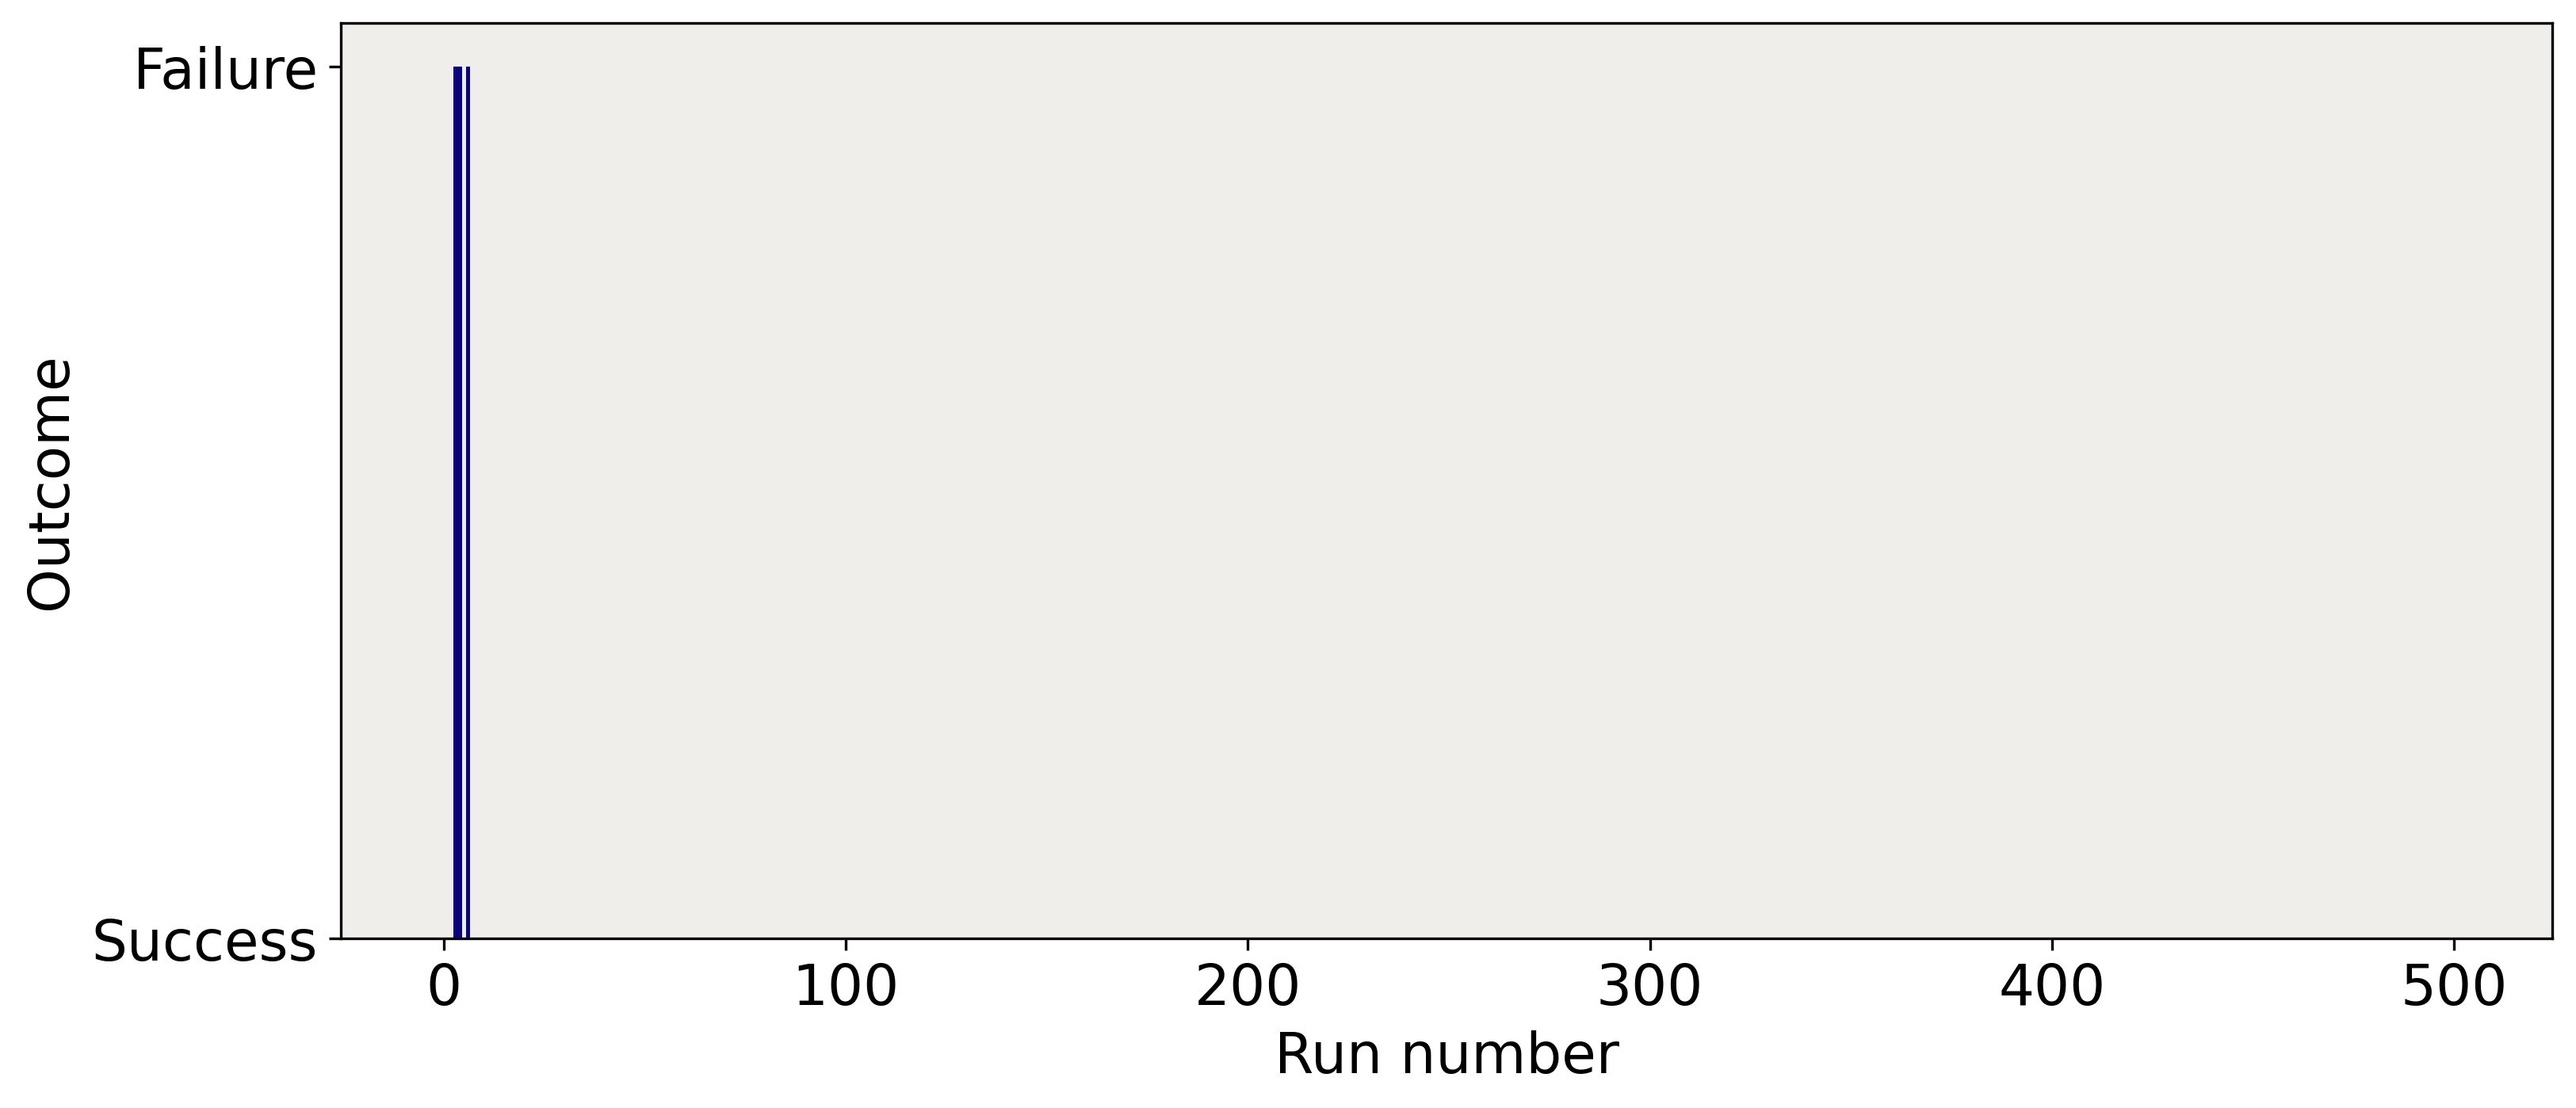

time: 0.18
alpha:  0.5 gamma:  0.9
reward 491.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


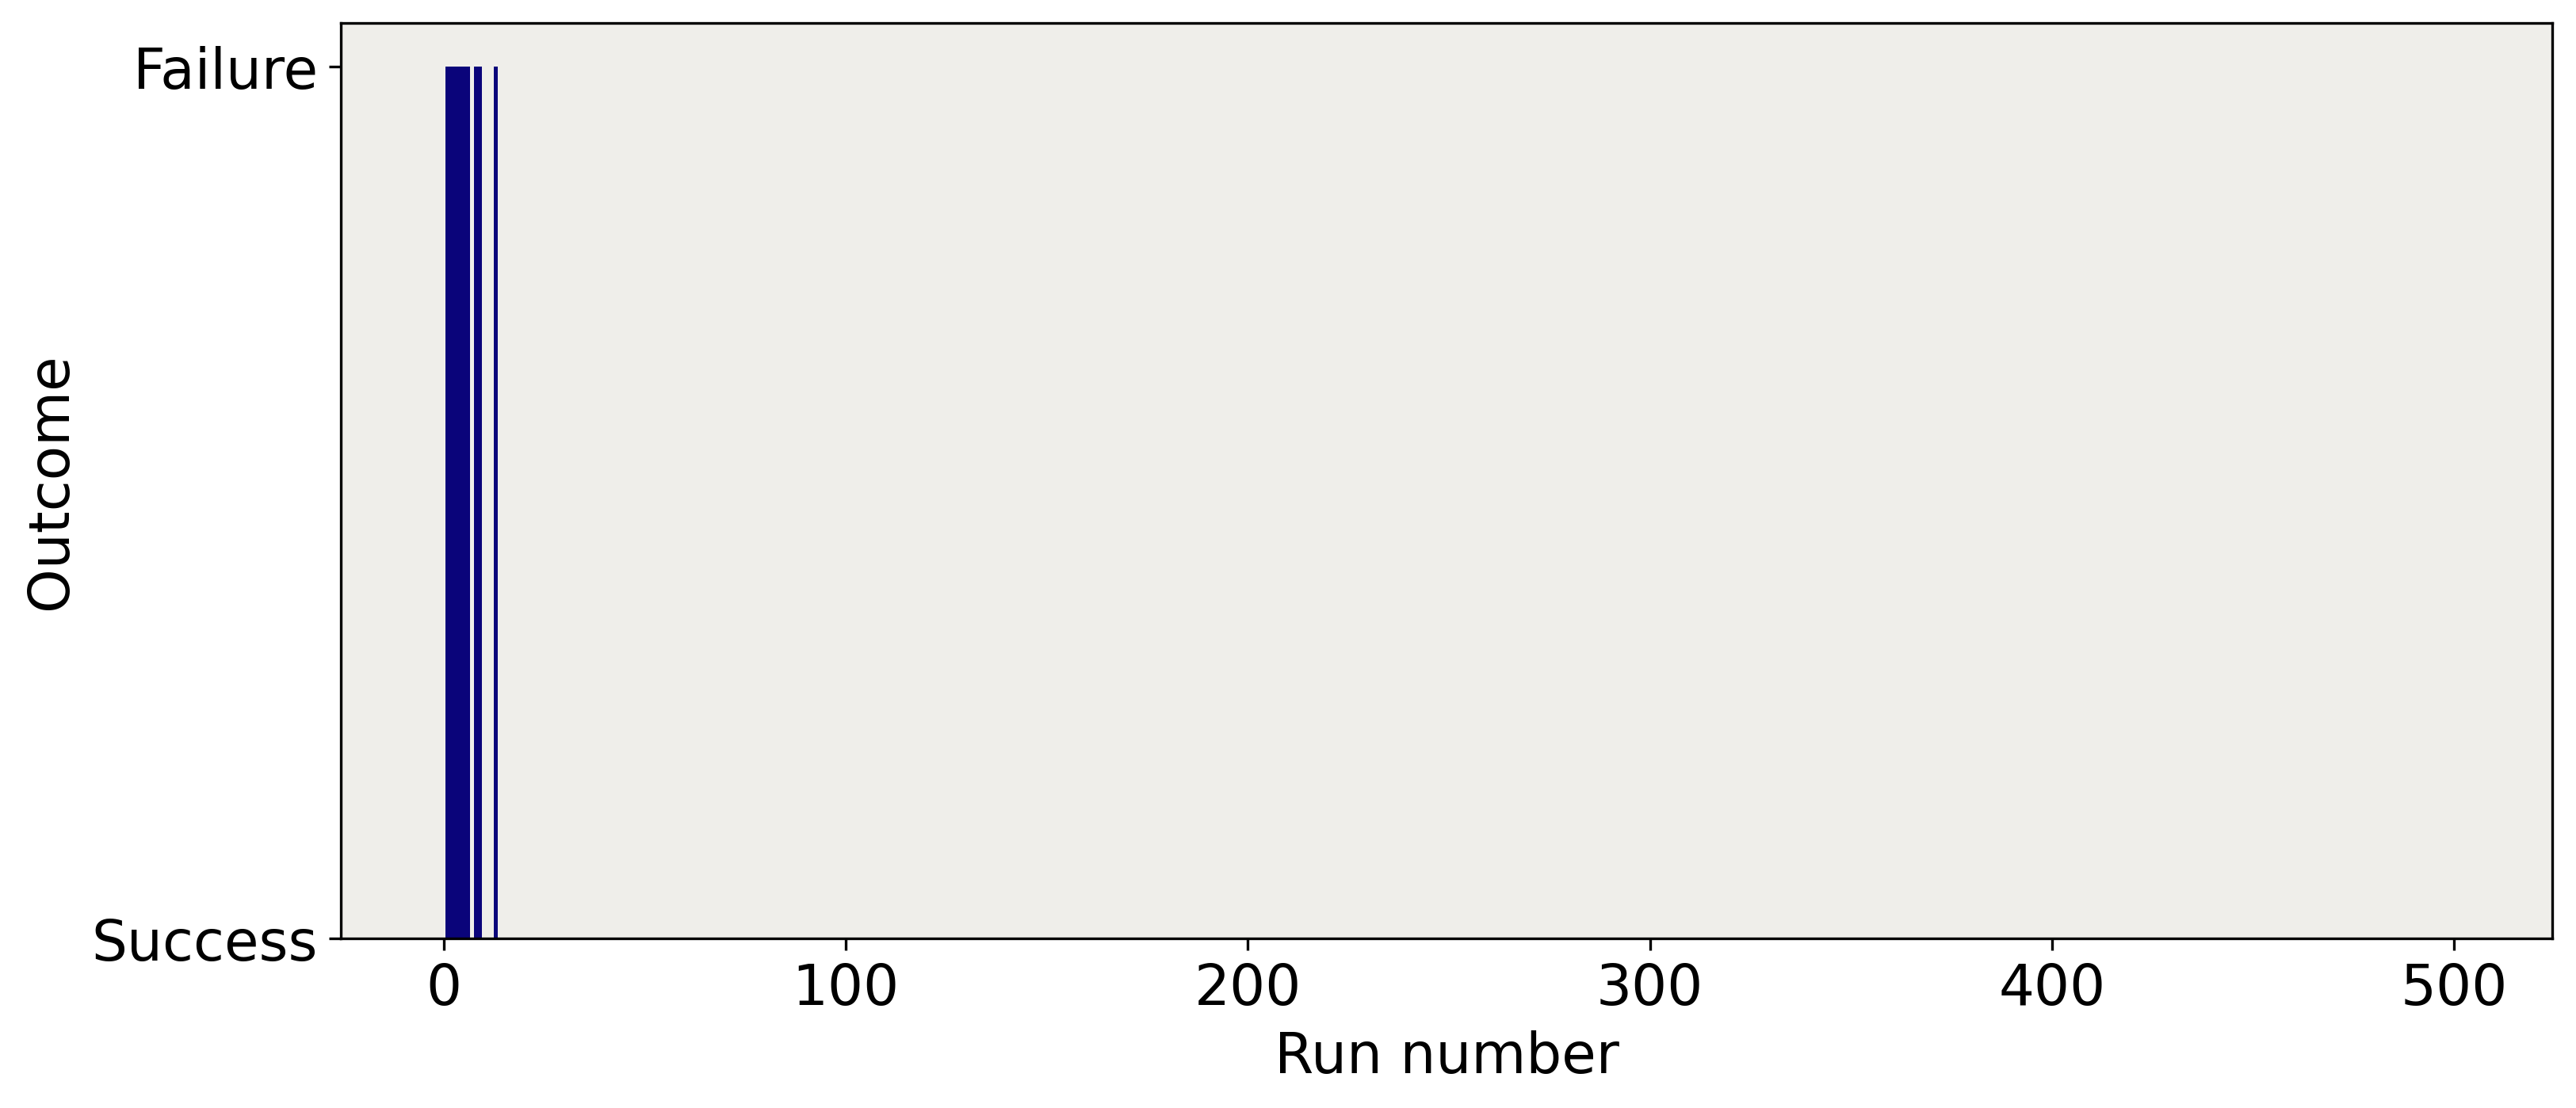

time: 0.159
alpha:  0.9 gamma:  0.01
reward 478.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


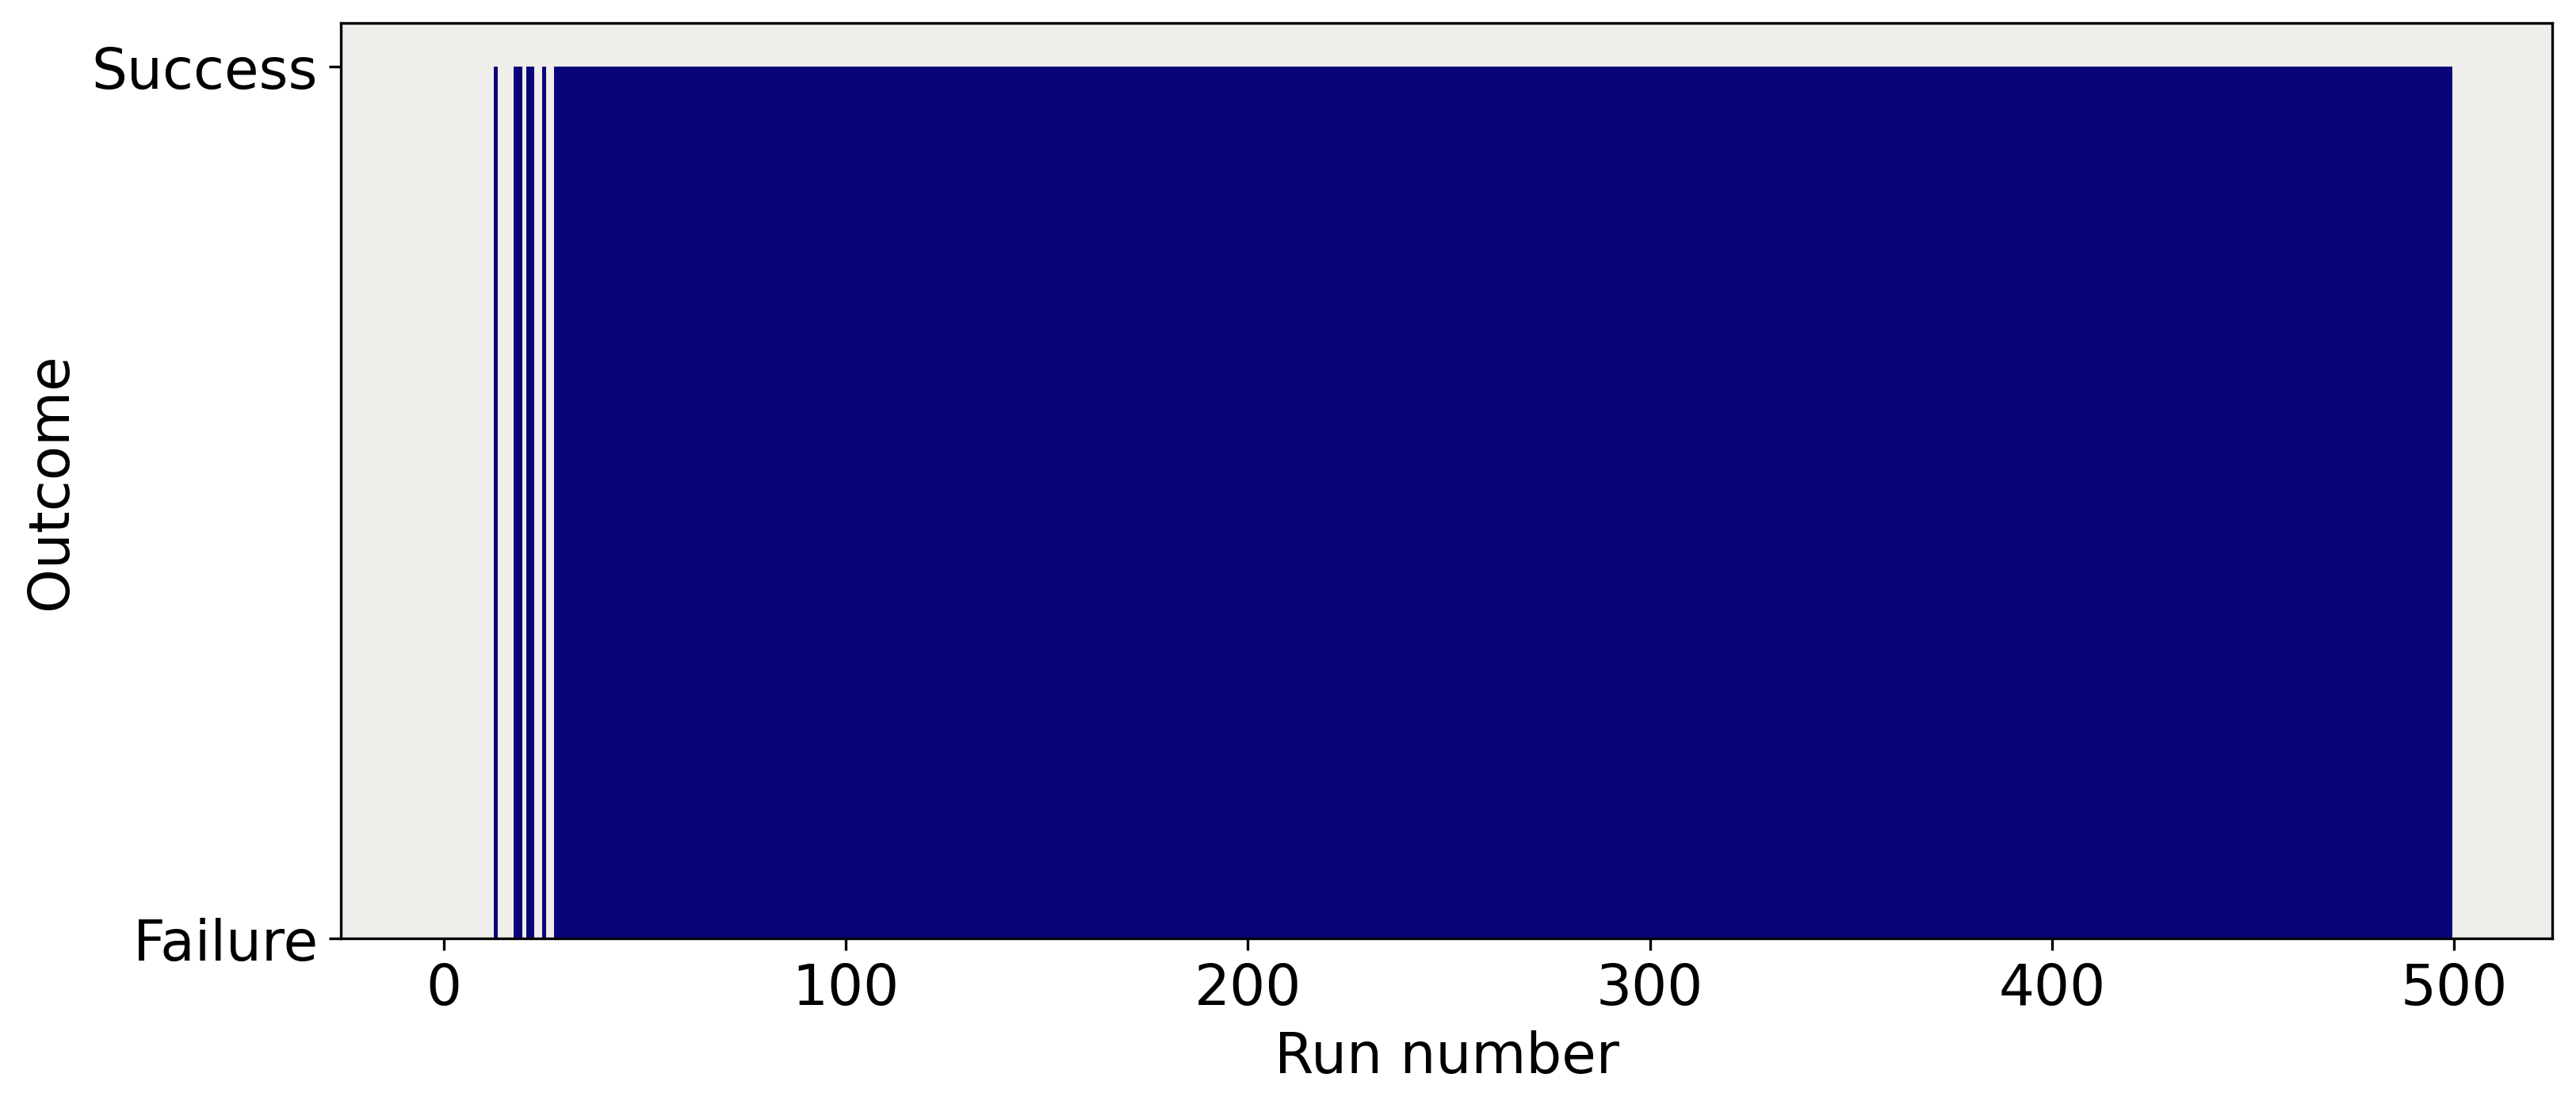

time: 0.141
alpha:  0.9 gamma:  0.5
reward 495.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


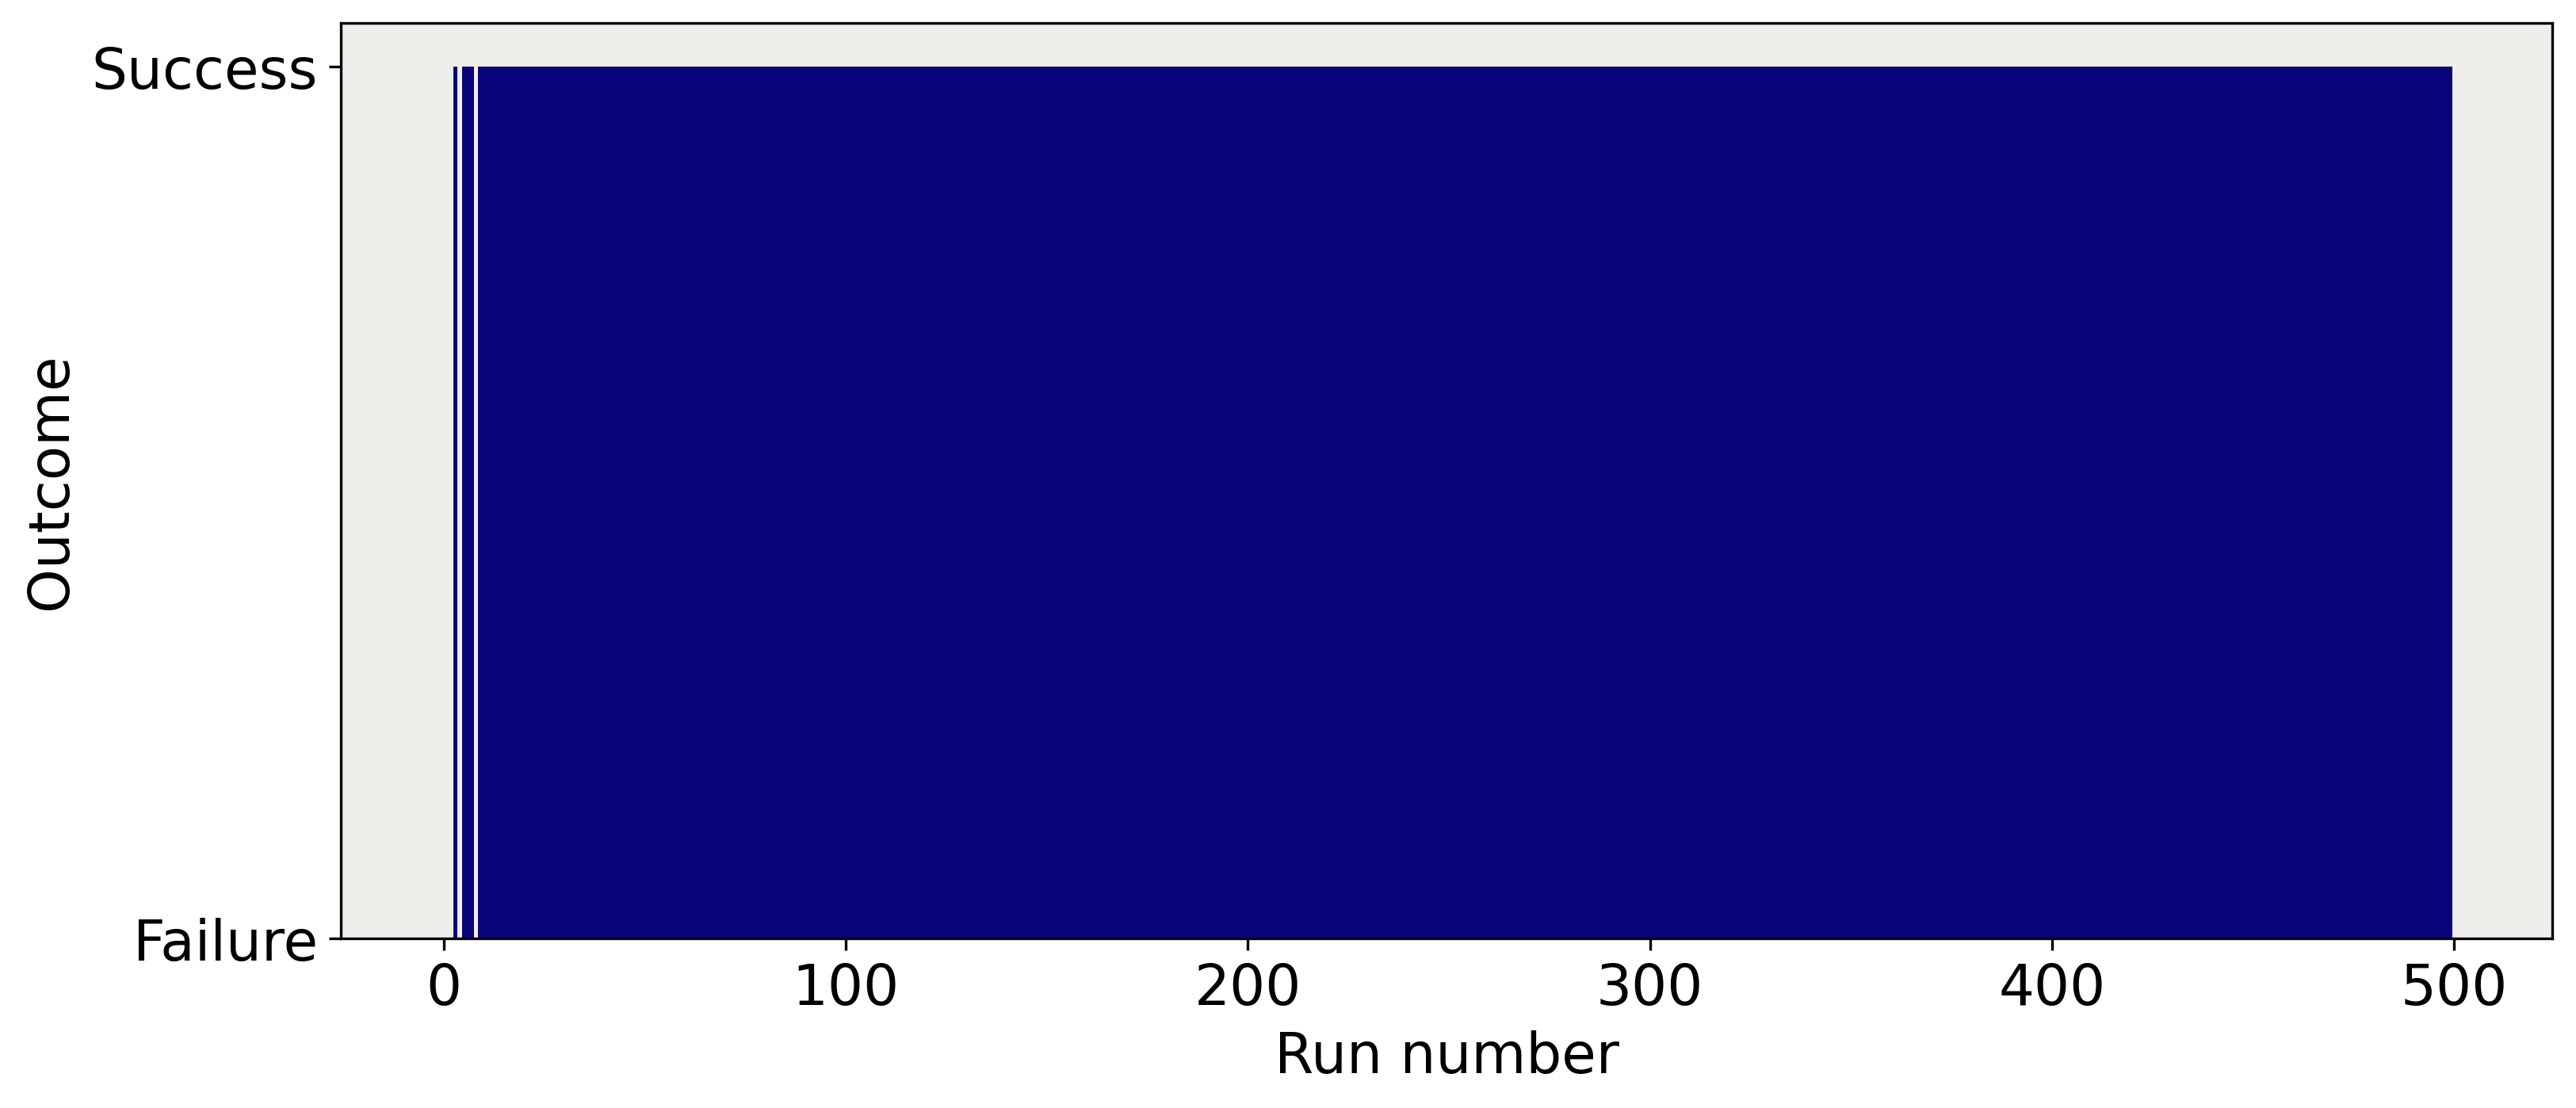

time: 0.222
alpha:  0.9 gamma:  0.9
reward 496.0
Success rate = 100.0%


<ipython-input-258-19c5d3c7b124>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo1 = qo1.append(qo)


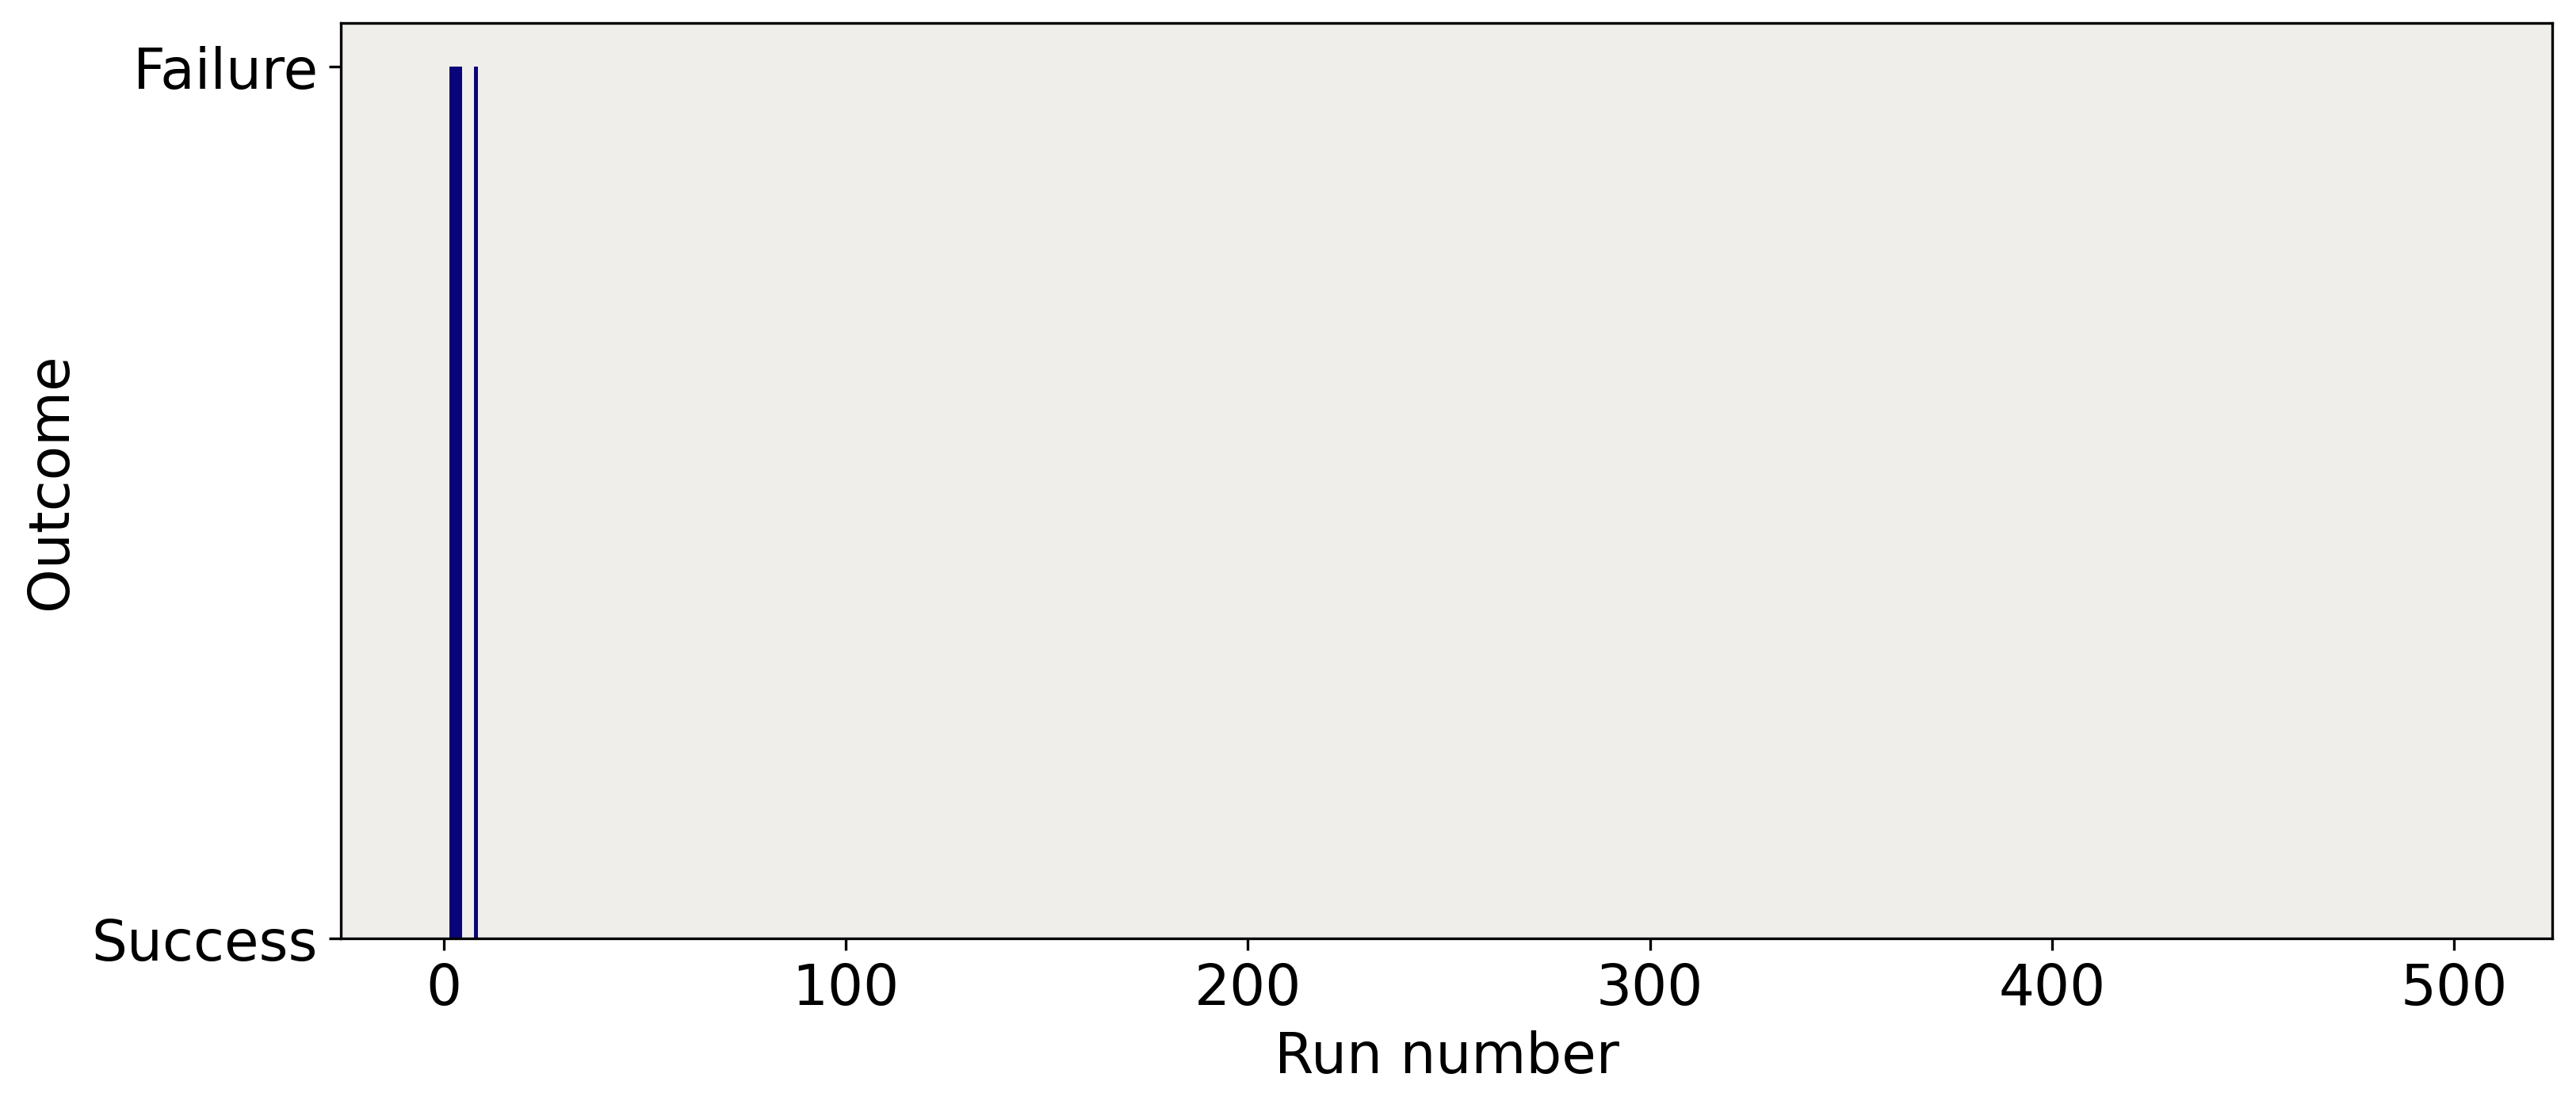

,gamma,learning rate,time,reward
0,0.01,0.01,0.155,497.0
0,0.50,0.01,0.230,490.0
0,0.90,0.01,0.206,497.0
0,0.01,0.50,0.183,492.0
0,0.50,0.50,0.188,497.0
0,0.90,0.50,0.180,491.0
0,0.01,0.90,0.159,478.0
0,0.50,0.90,0.141,495.0
0,0.90,0.90,0.222,496.0


,gamma,learning rate,time,reward
0,0.01,0.01,0.155,497.0
0,0.01,0.50,0.183,492.0
0,0.01,0.90,0.159,478.0
0,0.50,0.01,0.230,490.0
0,0.50,0.50,0.188,497.0
0,0.50,0.90,0.141,495.0
0,0.90,0.01,0.206,497.0
0,0.90,0.50,0.180,491.0
0,0.90,0.90,0.222,496.0


In [258]:
qo1 = pd.DataFrame()
random_map = generate_random_map(size=4, p=0.7)
env_name  = 'FrozenLake'
environment = gym.make(env_name, desc=random_map, is_slippery=False)
for alpha in [0.01, 0.5, 0.9]:
  for gamma in [0.01, 0.5, 0.9]:  
    import matplotlib.pyplot as plt
    
    environment.reset()
    # environment.render()


    # plt.rcParams['figure.dpi'] = 300
    # plt.rcParams.update({'font.size': 17})

    # We re-initialize the Q-table
    qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

    # Hyperparameters
    episodes = 500        # Total number of episodes
    # alpha = 0.5            # Learning rate
    # gamma = 0.9            # Discount factor

    # List of outcomes to plot
    outcomes = []
    rew = []
    # print('Q-table before training:')
    # print(qtable)

    # Training
    start = time.time()
    for _ in range(episodes):
        state = environment.reset()
        done = False

        # By default, we consider our outcome to be a failure
        outcomes.append("Failure")

        # Until the agent gets stuck in a hole or reaches the goal, keep training it
        while not done:
            # Choose the action with the highest value in the current state
            if np.max(qtable[state]) > 0:
              action = np.argmax(qtable[state])

            # If there's no best action (only zeros), take a random one
            else:
              action = environment.action_space.sample()
                
            # Implement this action and move the agent in the desired direction
            new_state, reward, done, info = environment.step(action)

            # Update Q(s,a)
            qtable[state, action] = qtable[state, action] + \
                                    alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
            
            # Update our current state
            state = new_state
            rew.append(reward)

            # If we have a reward, it means that our outcome is a success
            if reward:
              outcomes[-1] = "Success"

    print('===========================================')
    end = time.time()-start
    print('time:', np.round(end,3))
    print('alpha: ', alpha, 'gamma: ', gamma)
    print('reward', np.sum(rew))
    eval(environment, qtable)
    # print('Q-table after training:')
    # print(qtable)
    qo = pd.DataFrame({
        'gamma':[gamma],
        'learning rate':[alpha],
        'time': [np.round(end,3)],
        'reward': [np.sum(rew)]
    })
    qo1 = qo1.append(qo)

    # Plot outcomes
    plt.figure(figsize=(12, 5))
    plt.xlabel("Run number")
    plt.ylabel("Outcome")
    ax = plt.gca()
    ax.set_facecolor('#efeeea')
    plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
    plt.show()

display(qo1)
display(qo1.sort_values('gamma'))


# qlearn16x16

/usr/local/lib/python3.9/dist-packages/gym/envs/registration.py:601: UserWarning: WARN: Using the latest versioned environment `FrozenLake-v1` instead of the unversioned environment `FrozenLake`.
  logger.warn(


time: 139.245
alpha:  0.9 gamma:  0.9
reward 8082.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


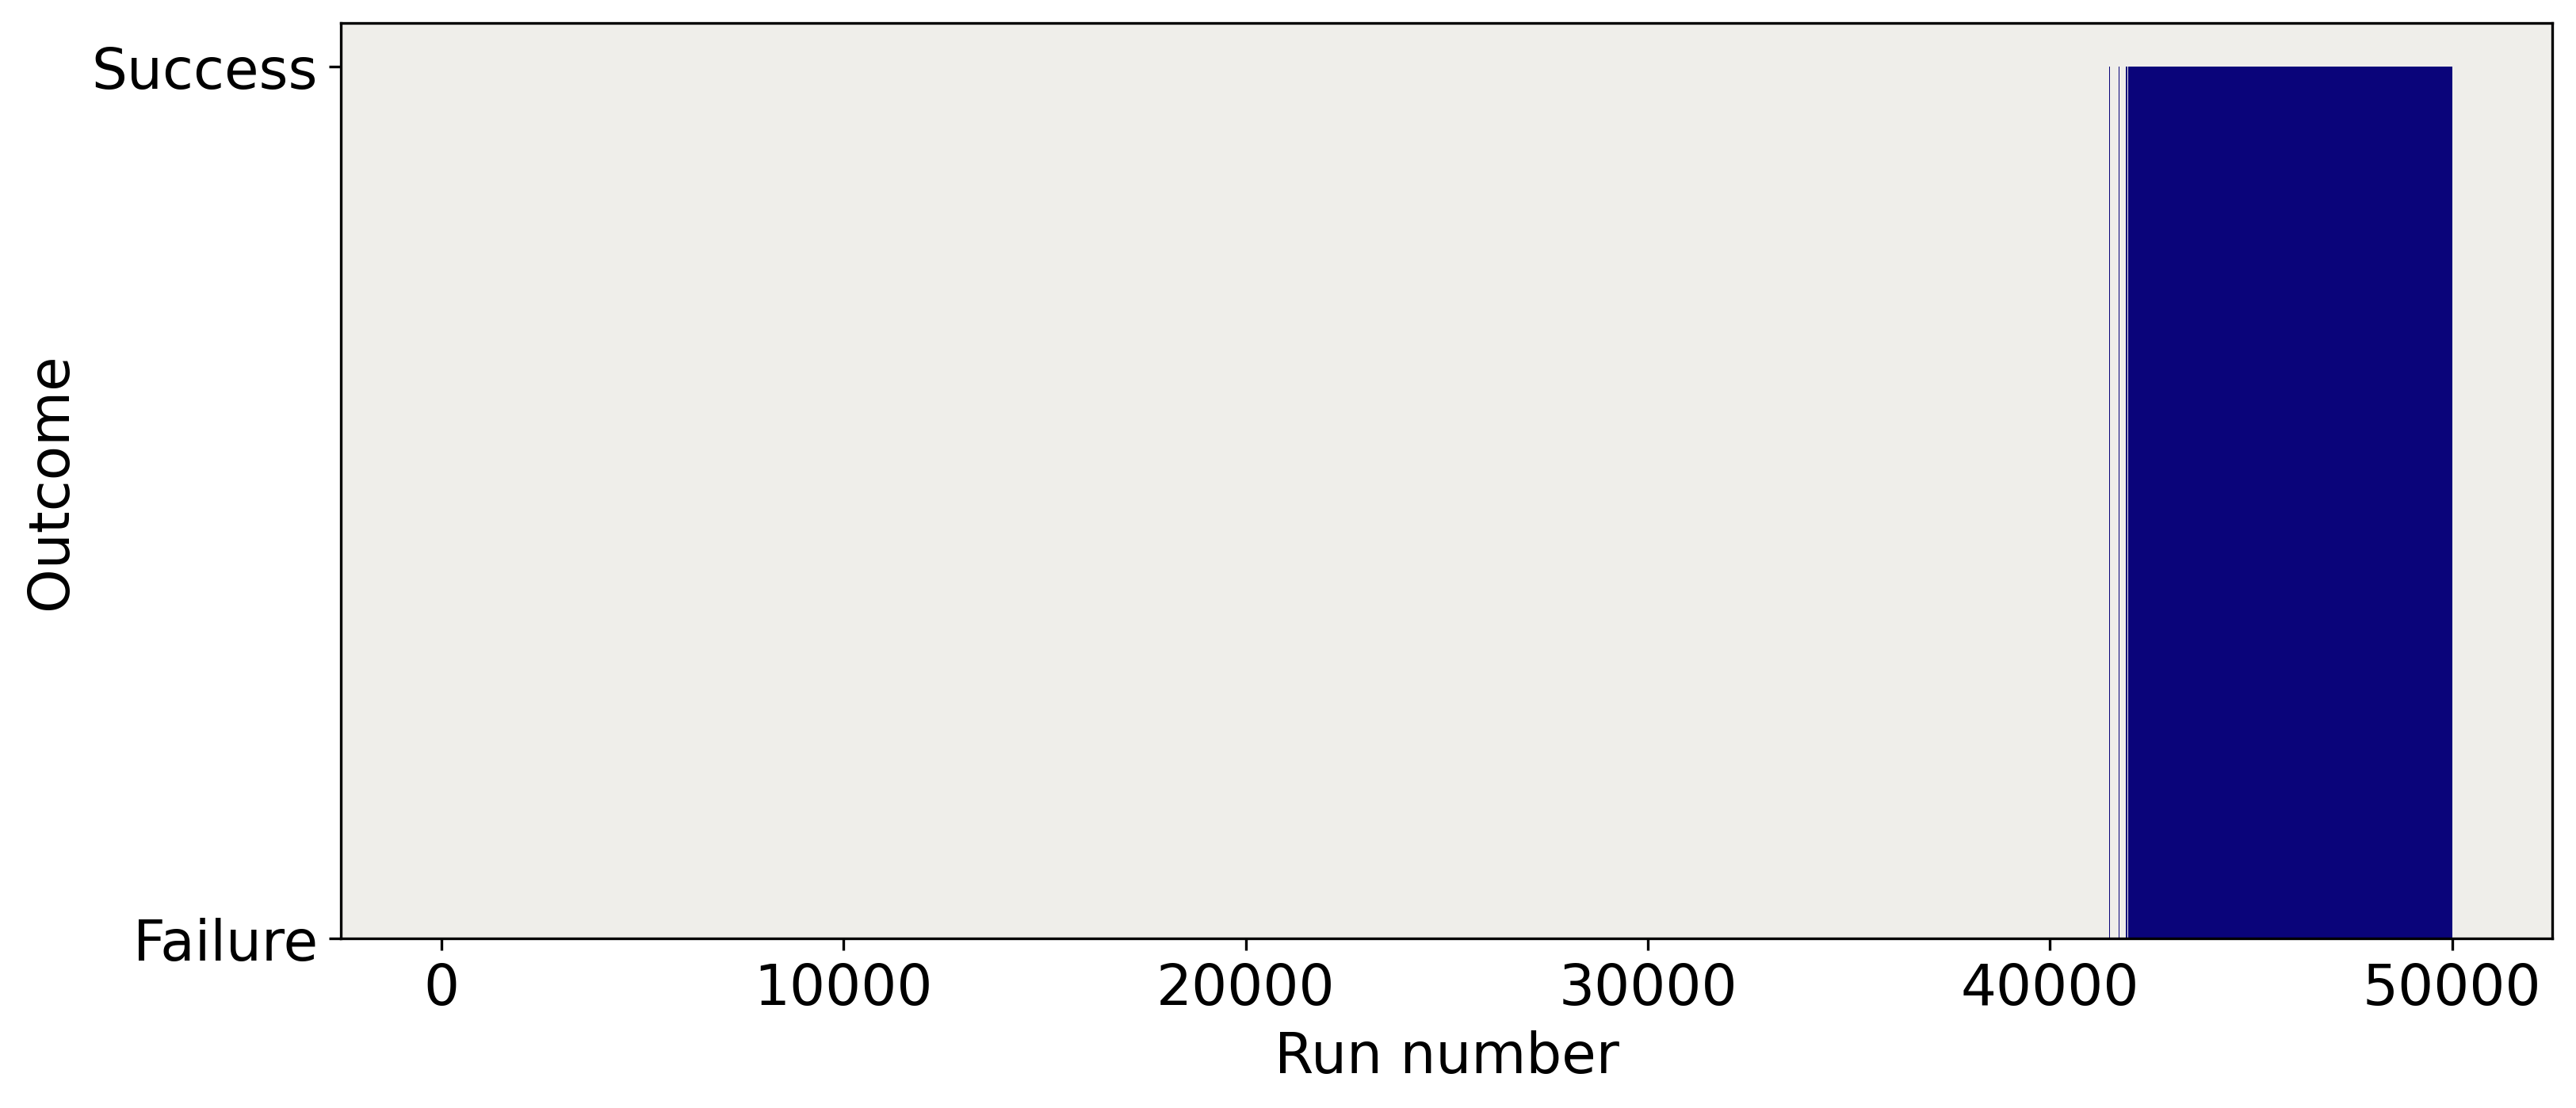

time: 93.286
alpha:  0.9 gamma:  0.5
reward 32811.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


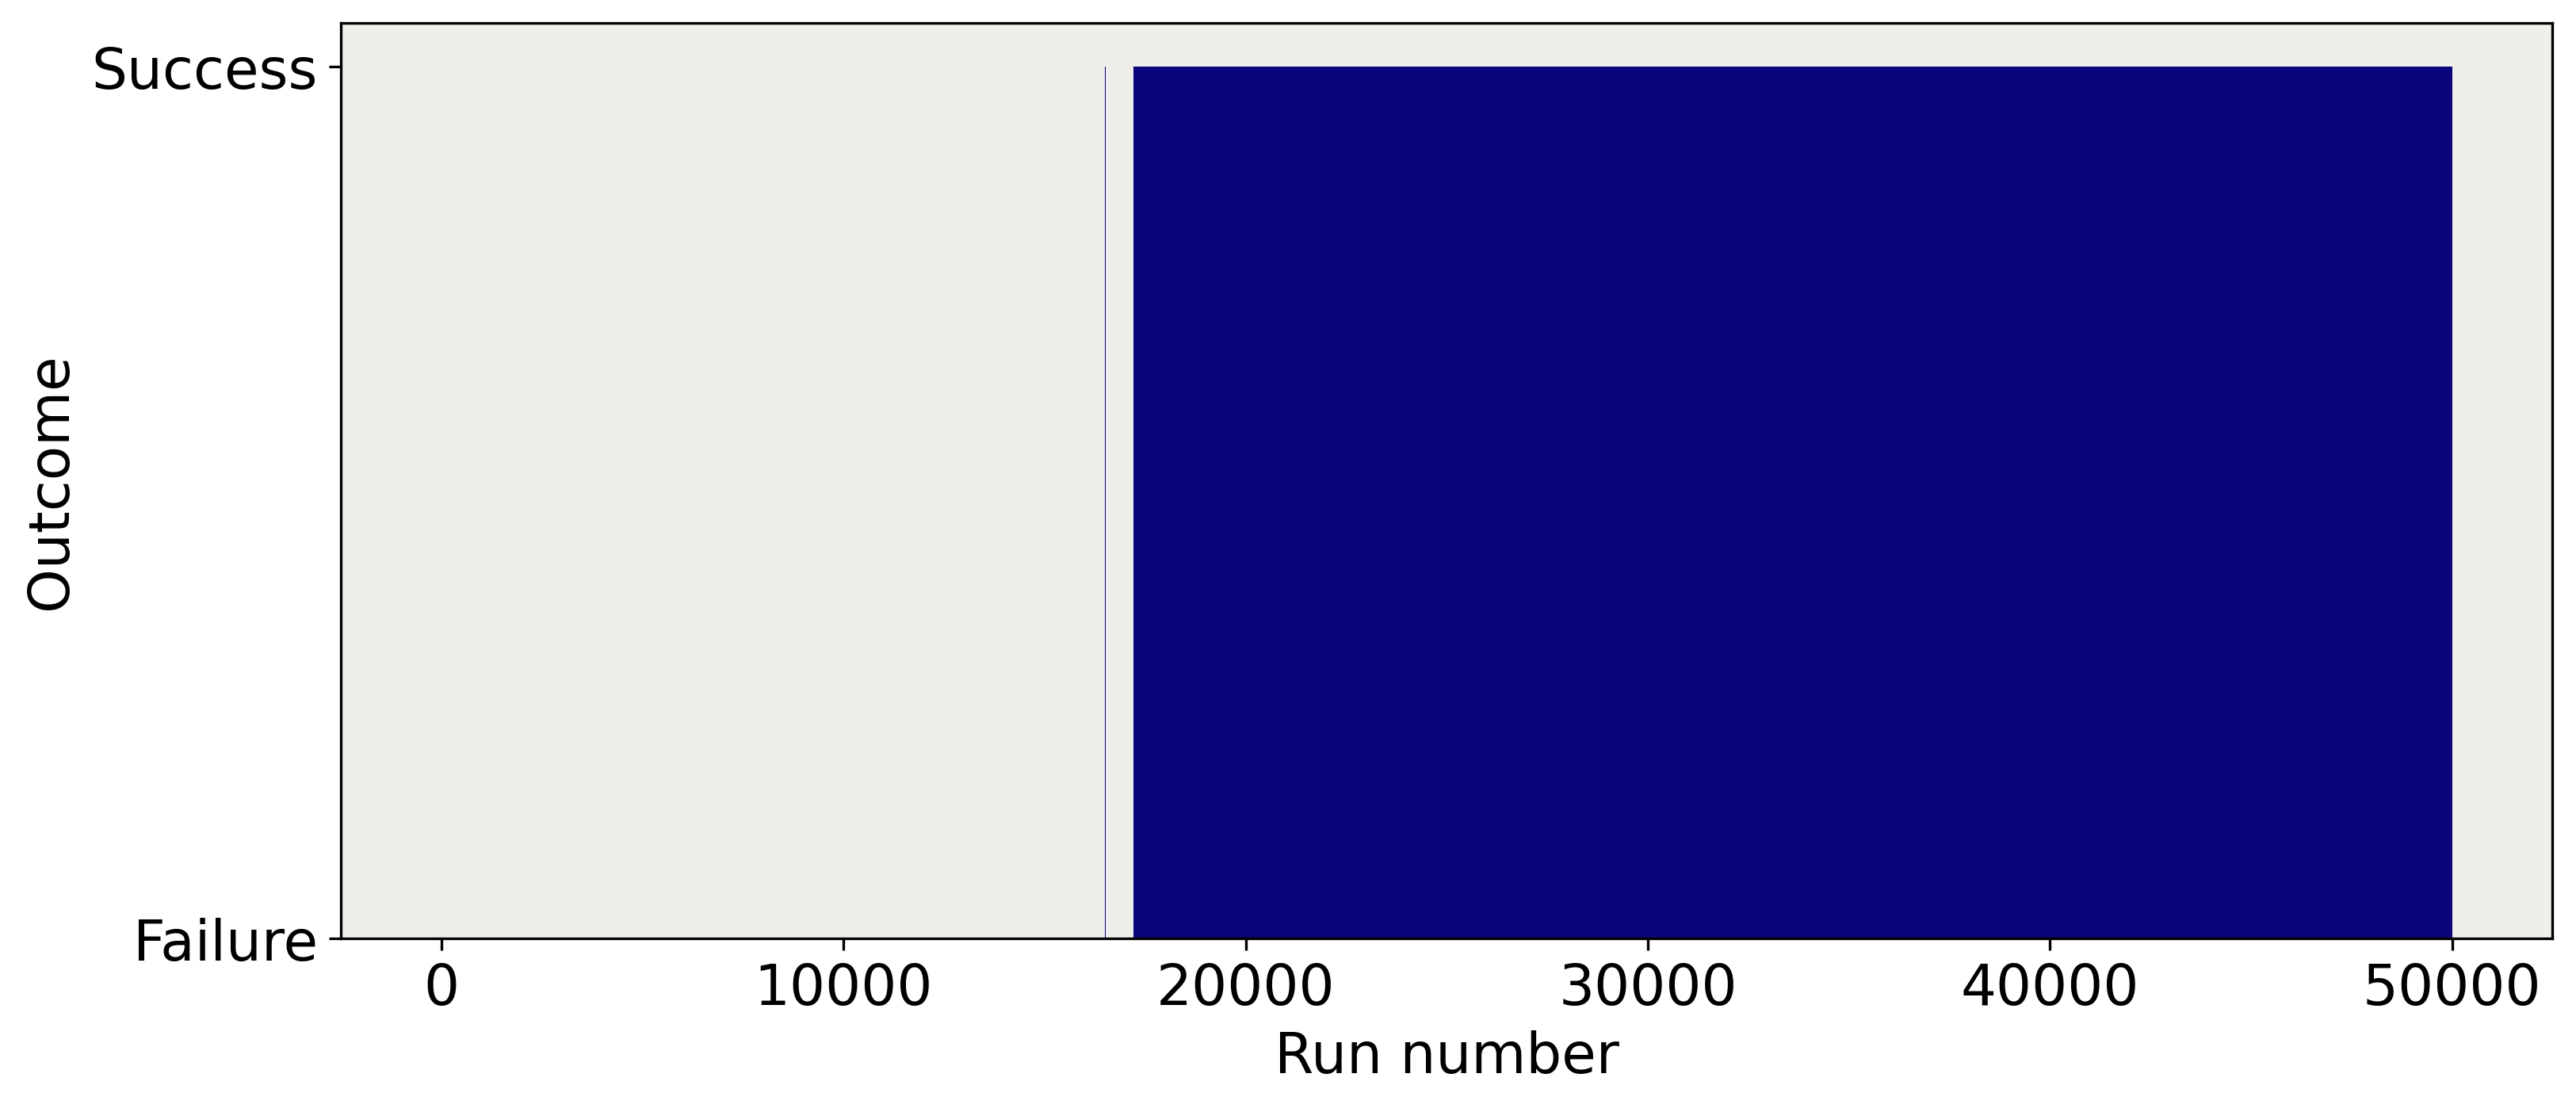

time: 125.827
alpha:  0.9 gamma:  0.01
reward 8767.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


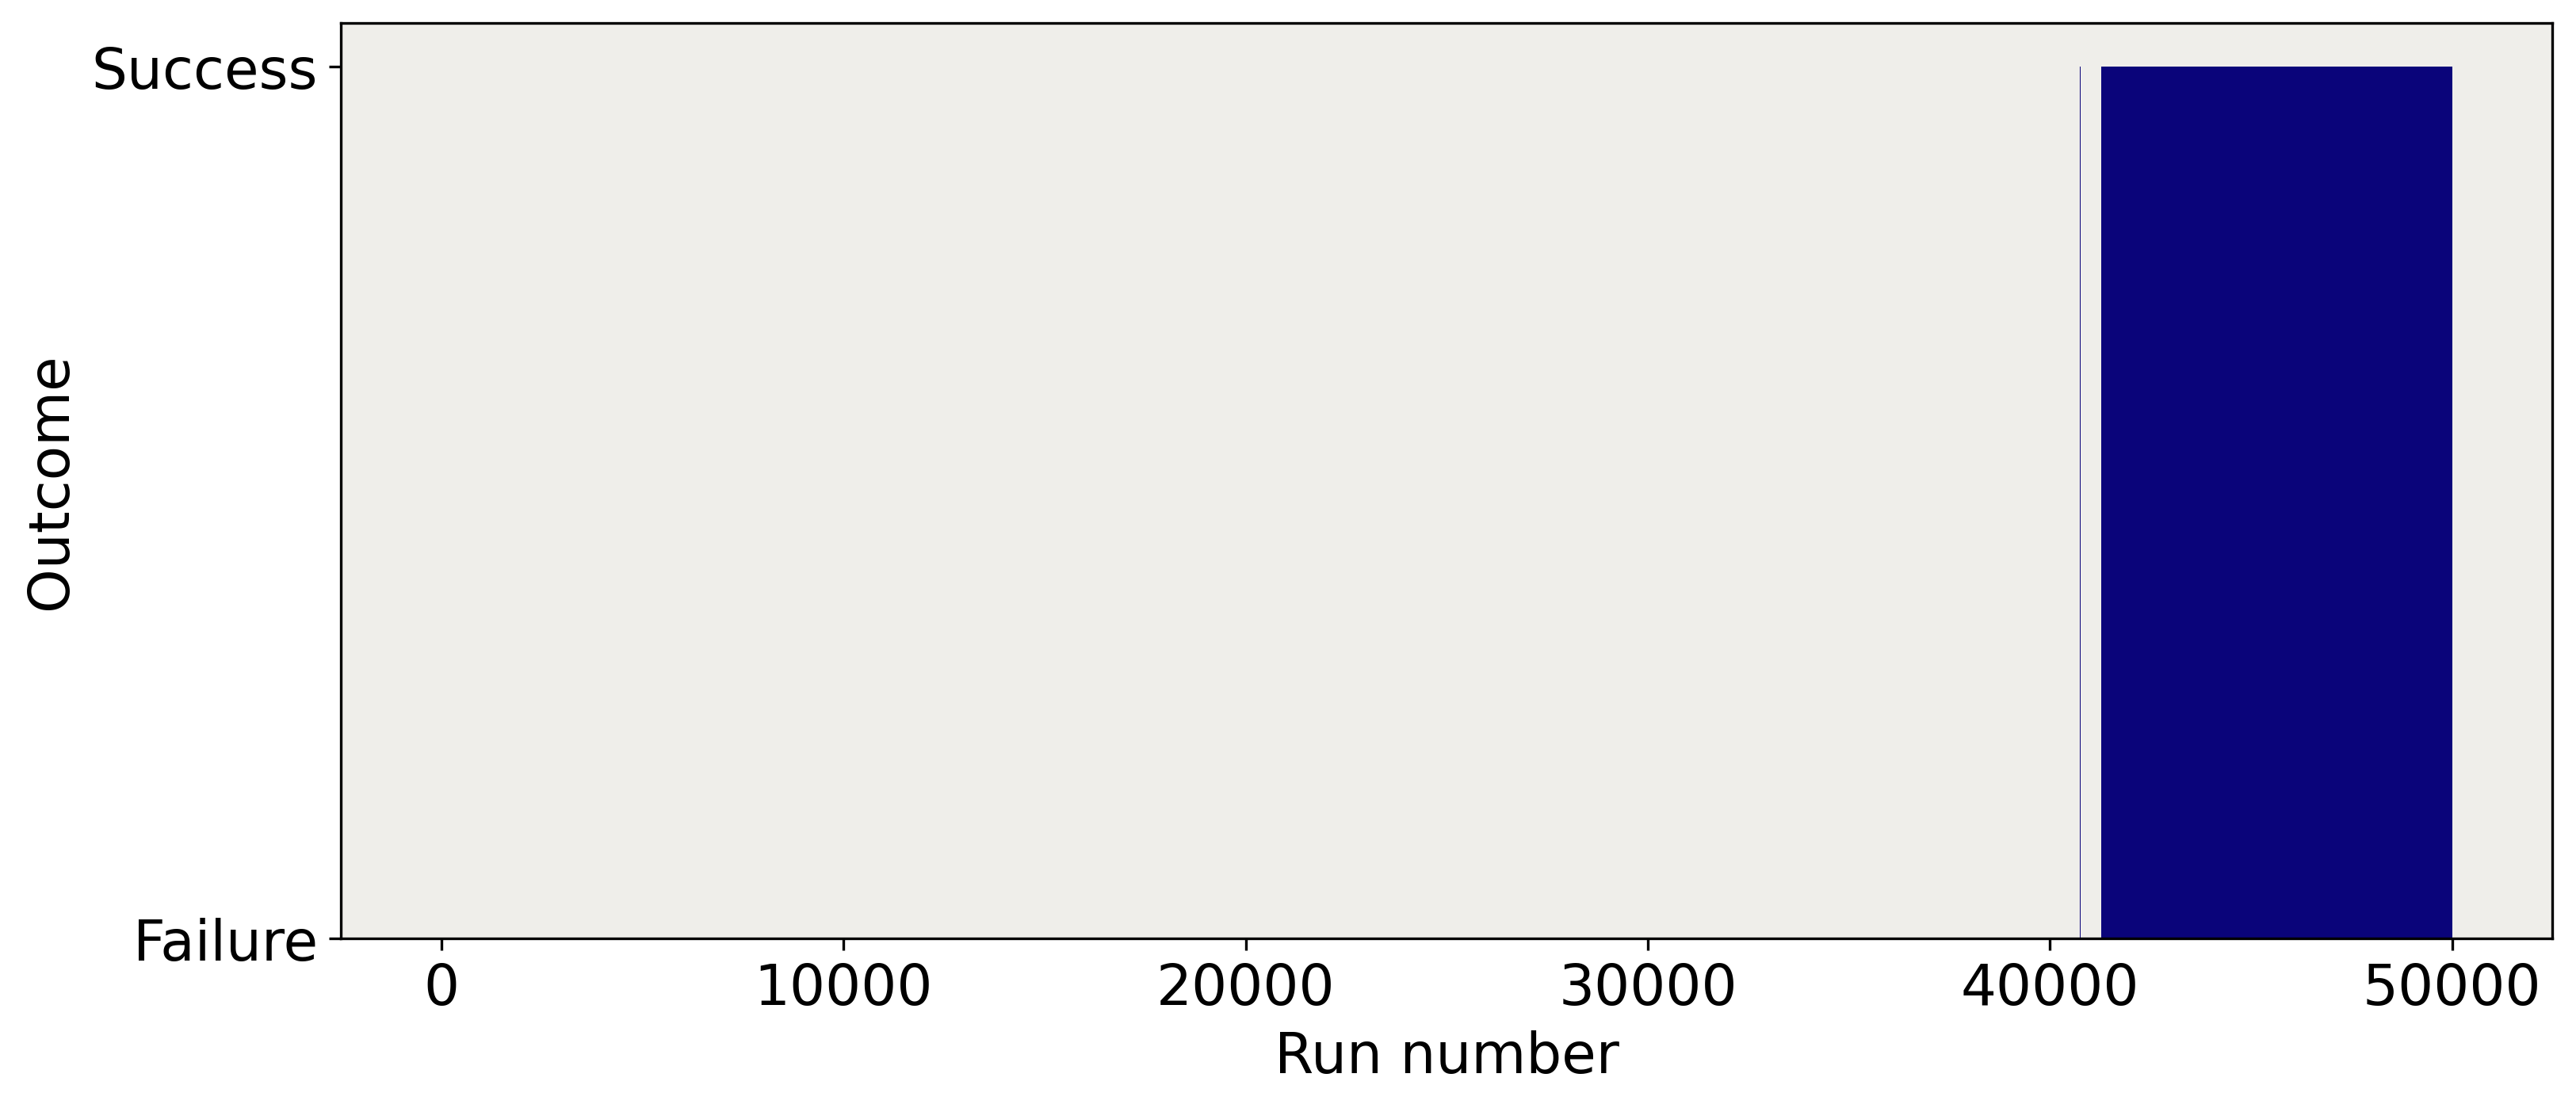

time: 112.739
alpha:  0.5 gamma:  0.9
reward 22410.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


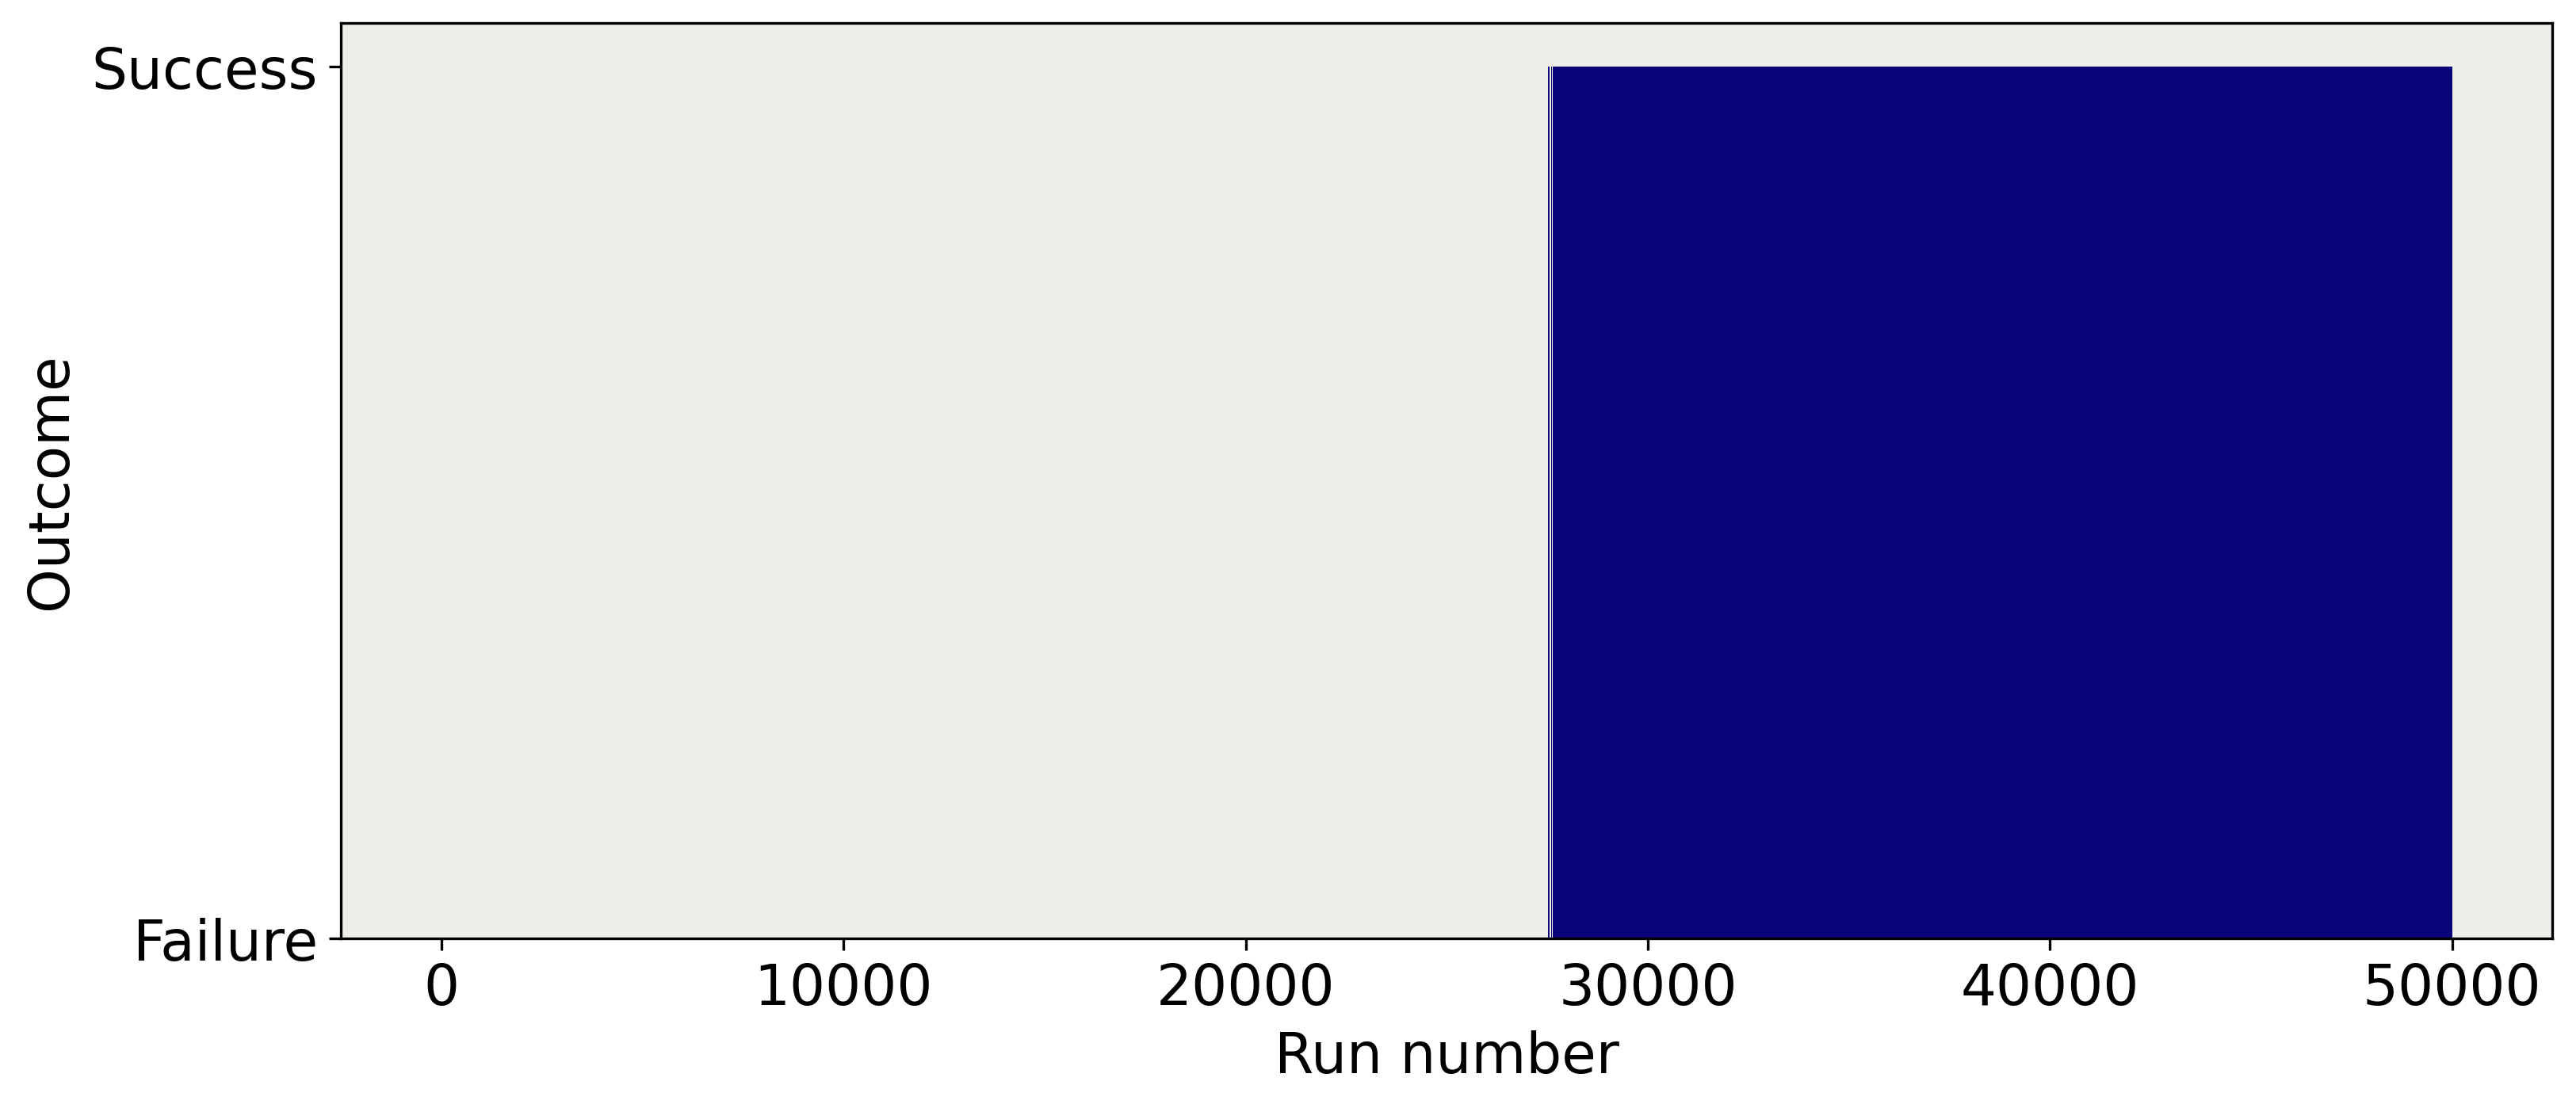

time: 111.53
alpha:  0.5 gamma:  0.5


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


reward 16966.0


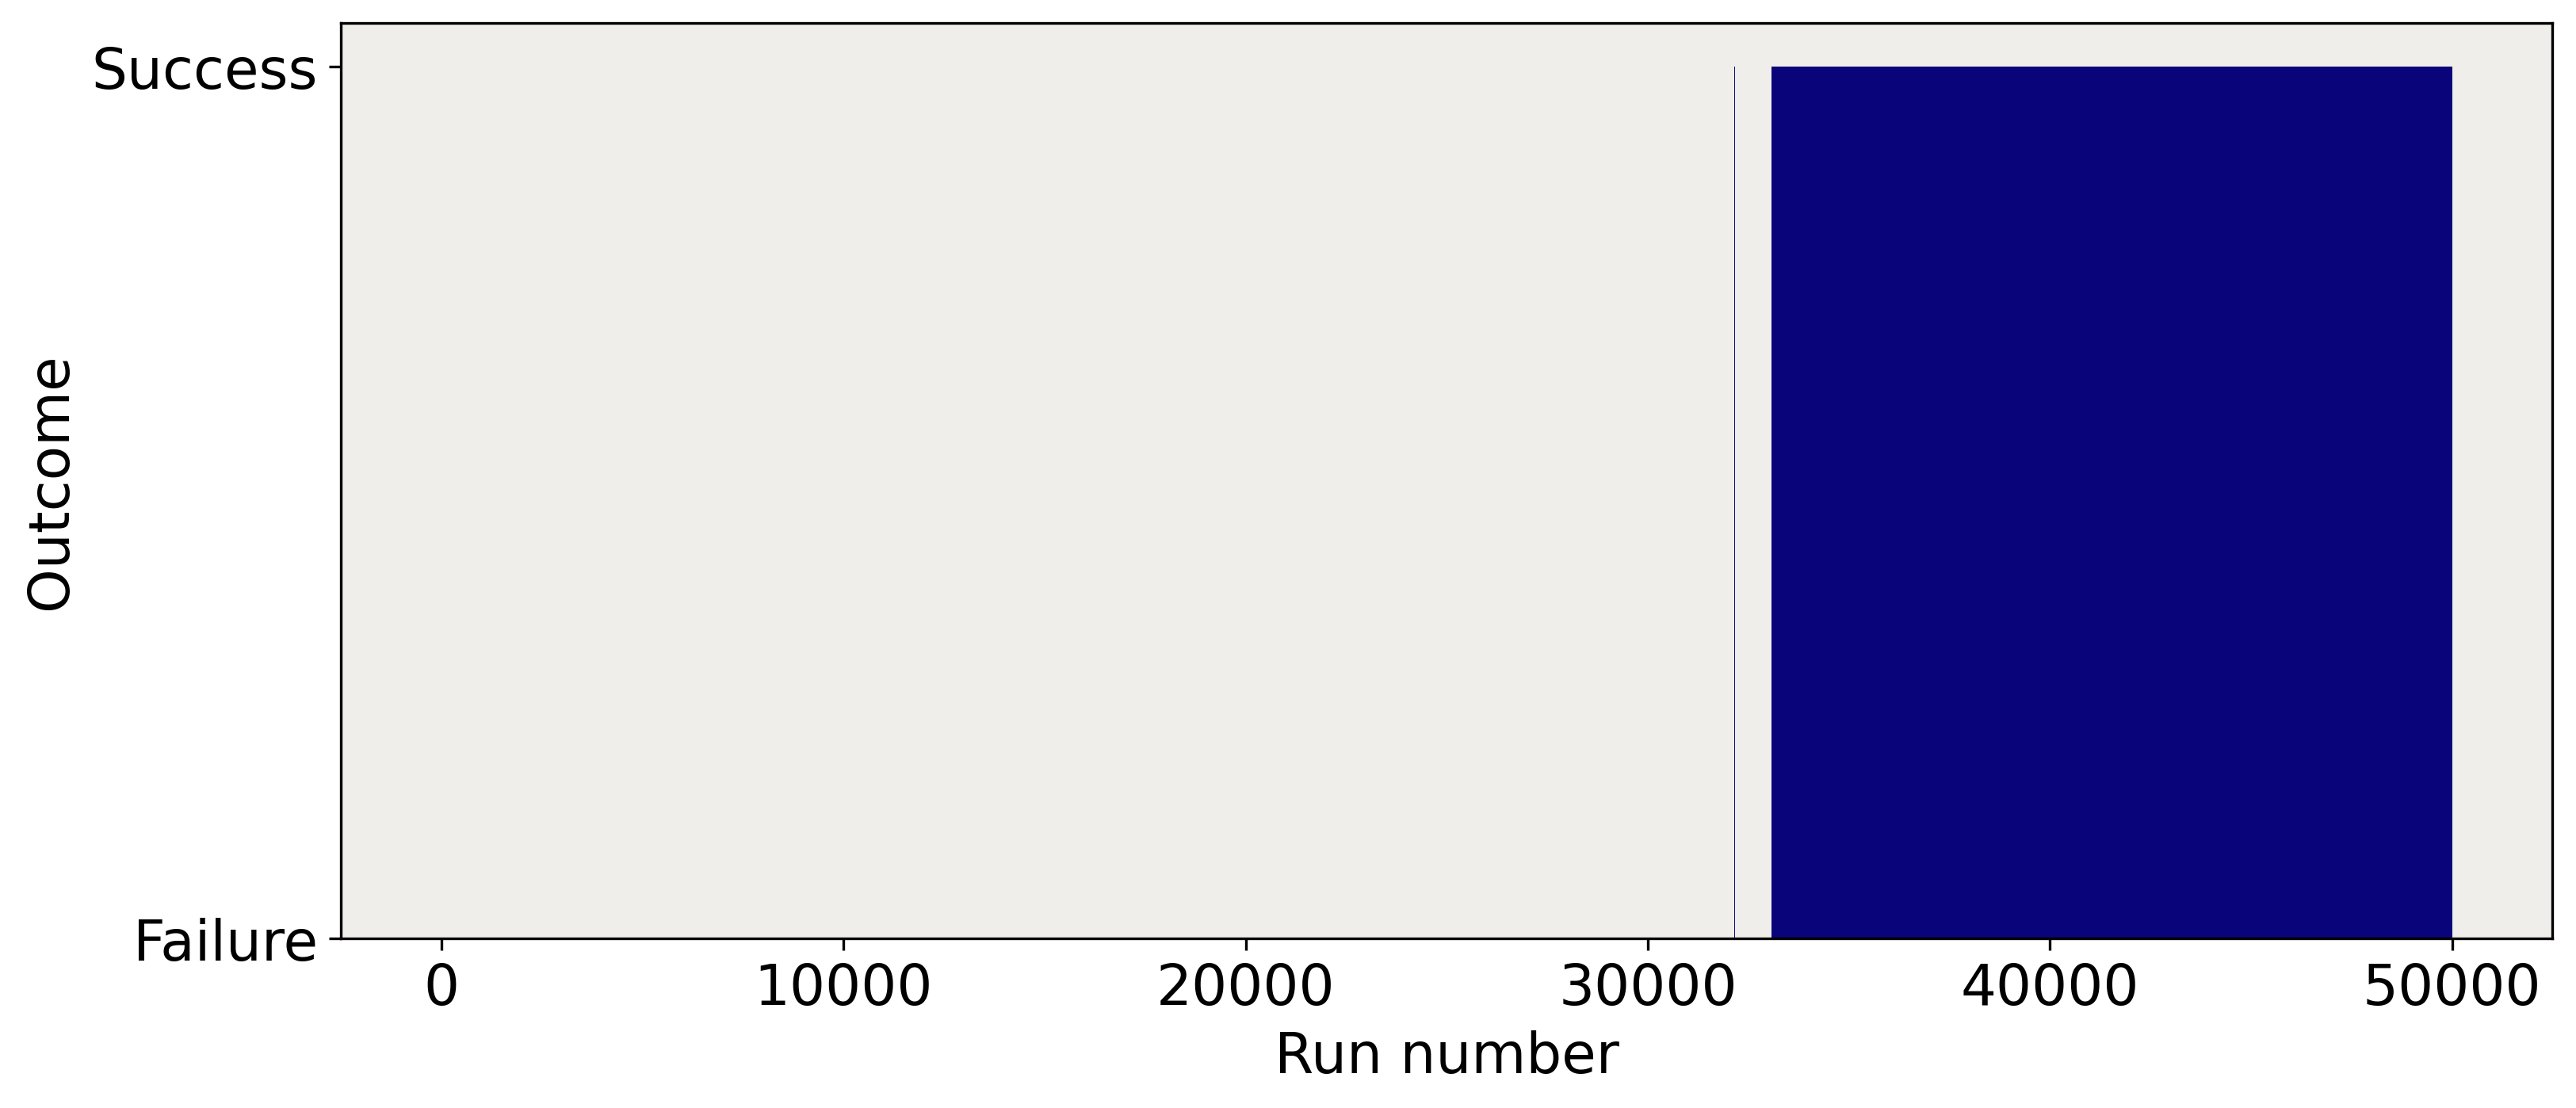

time: 138.542
alpha:  0.5 gamma:  0.01
reward 3.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


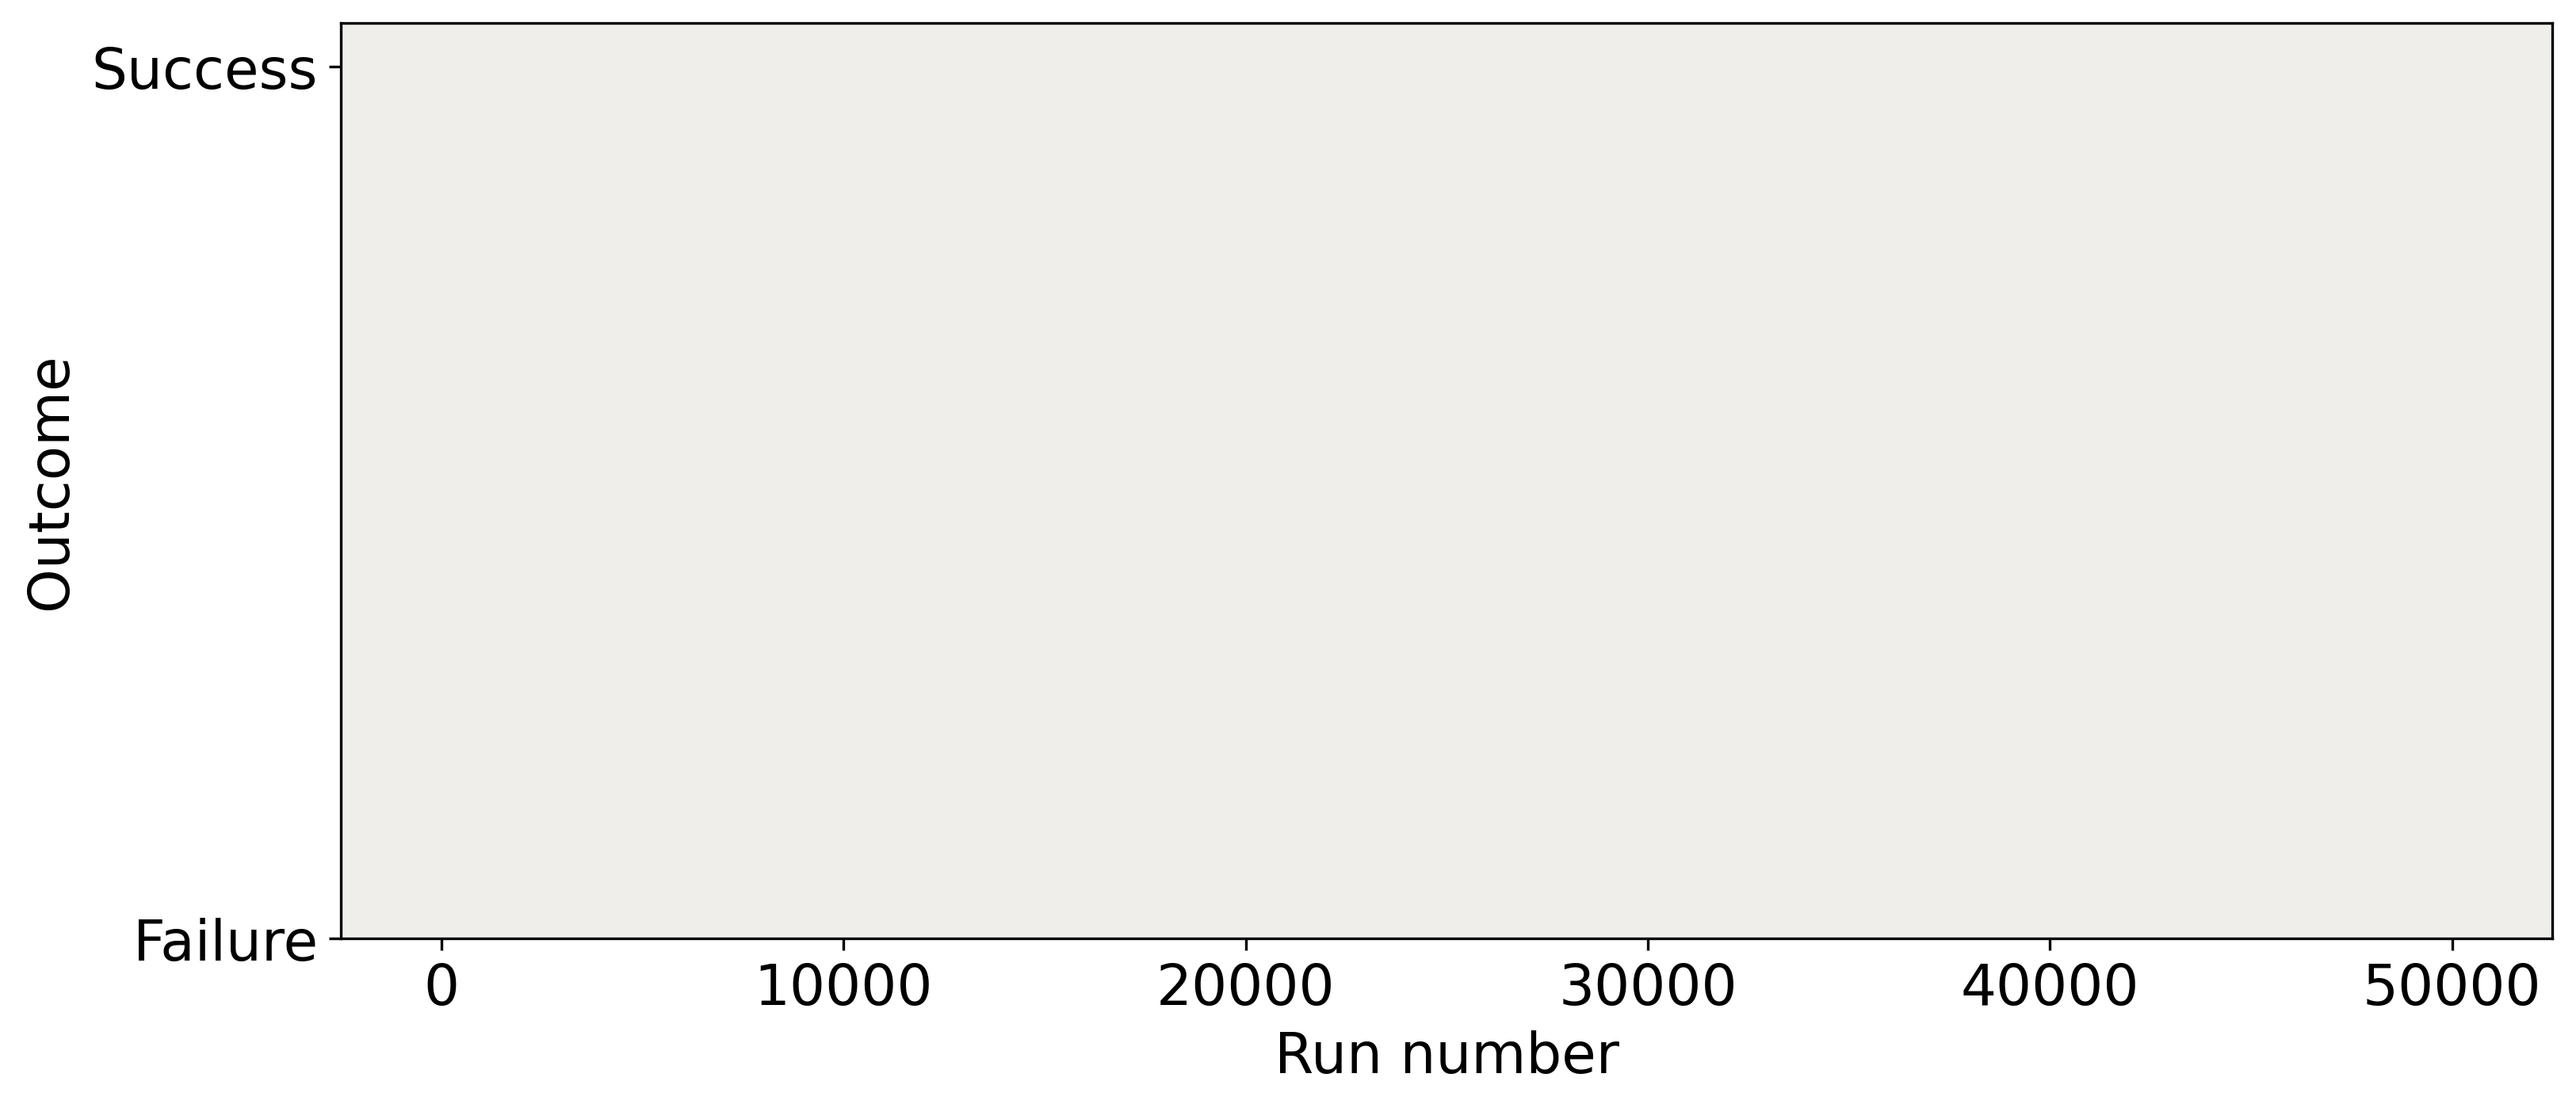

time: 115.314
alpha:  0.01 gamma:  0.9
reward 14407.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


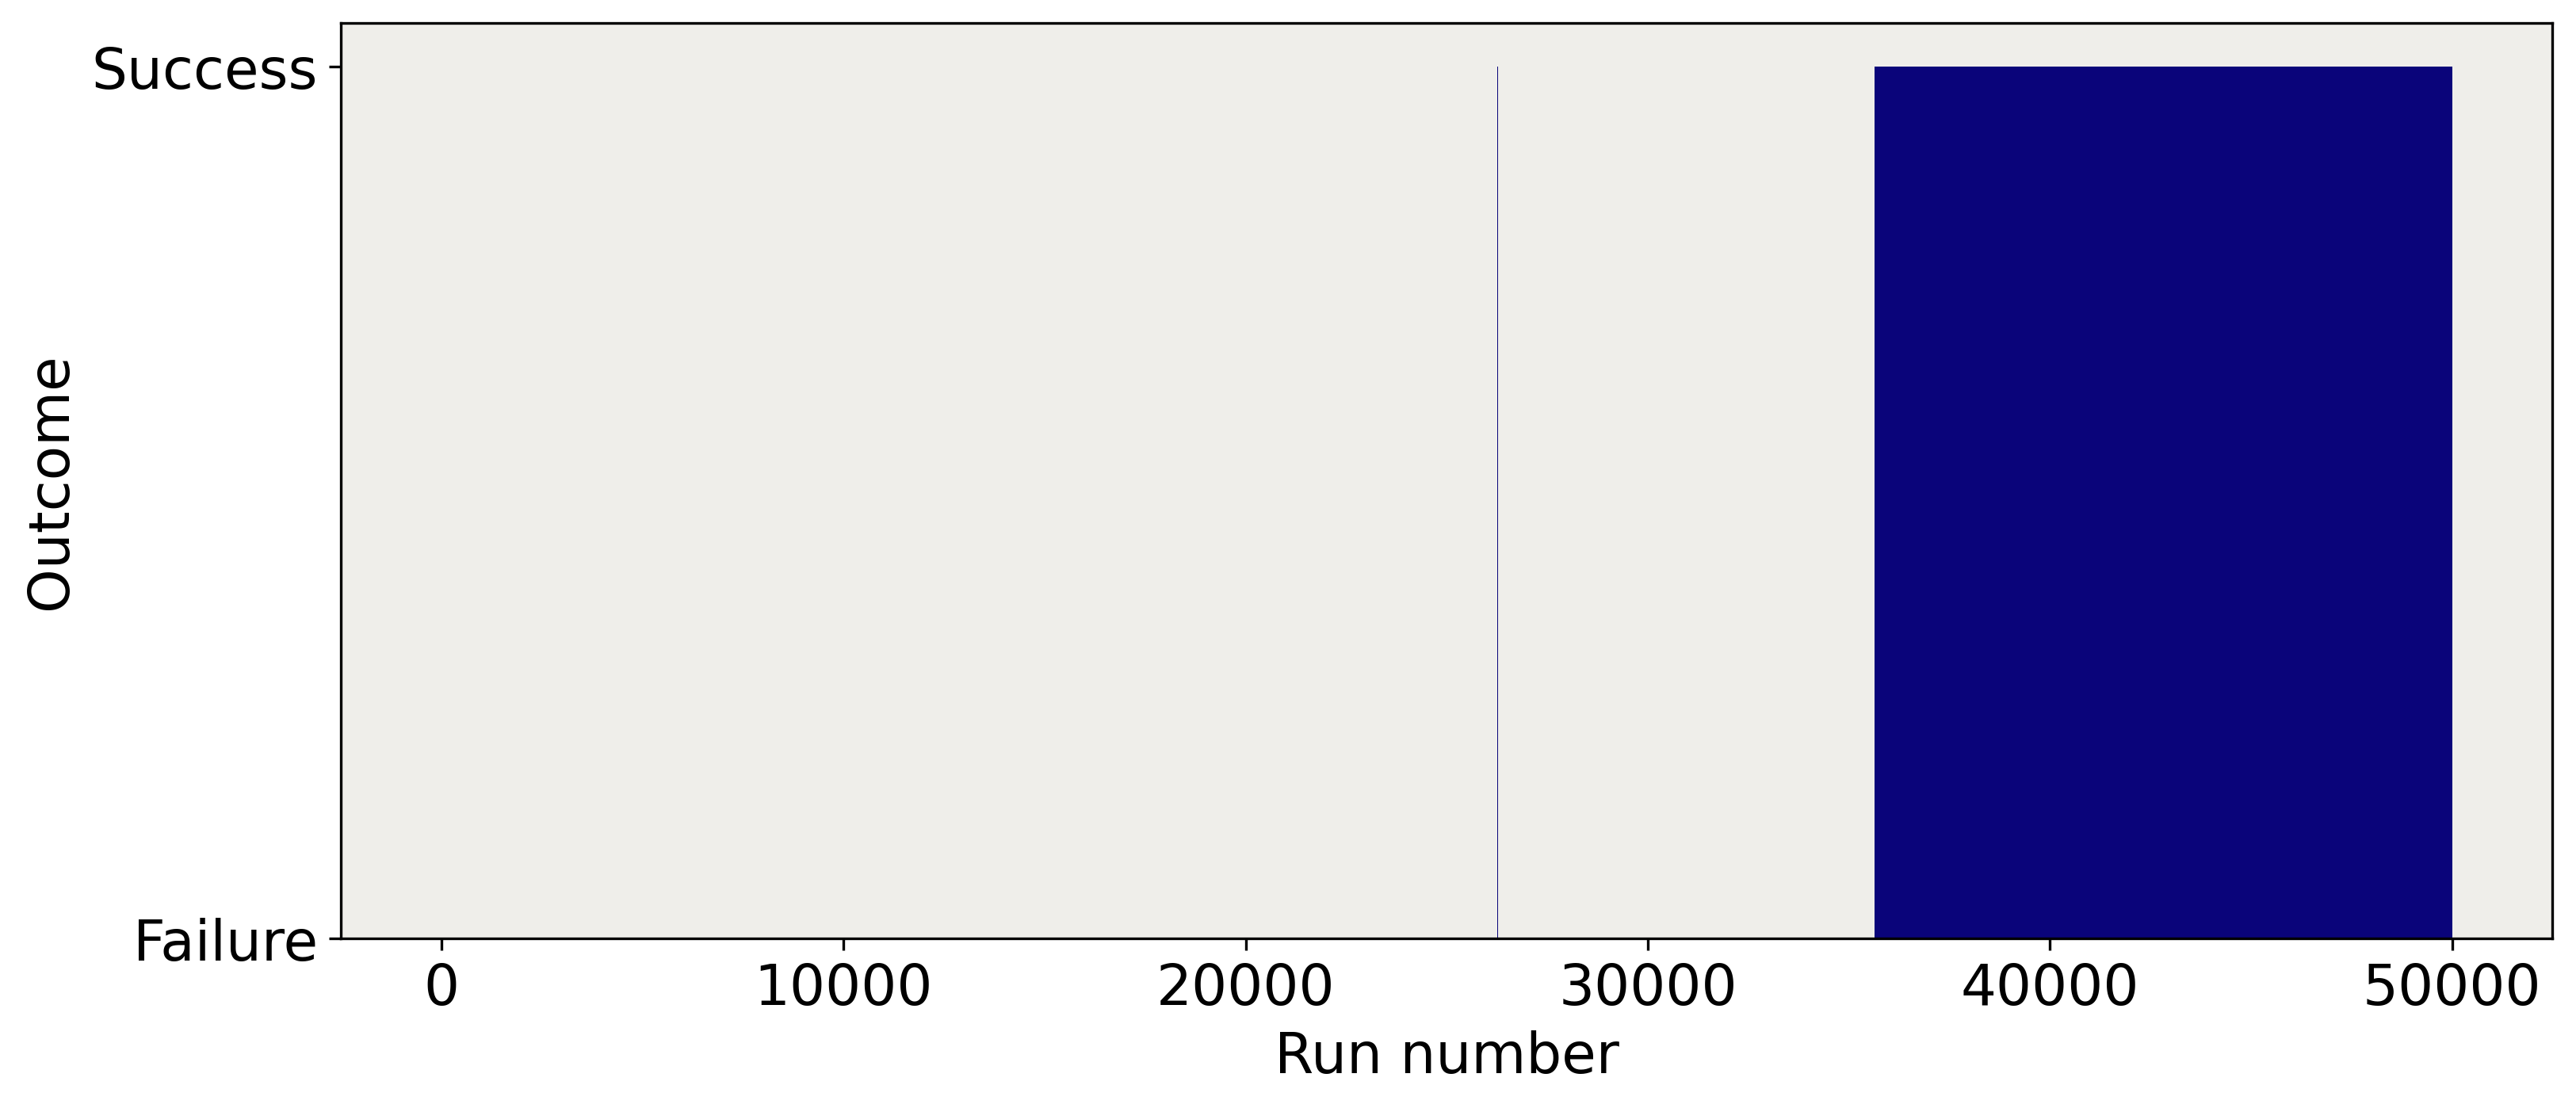

time: 133.81
alpha:  0.01 gamma:  0.5
reward 9.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


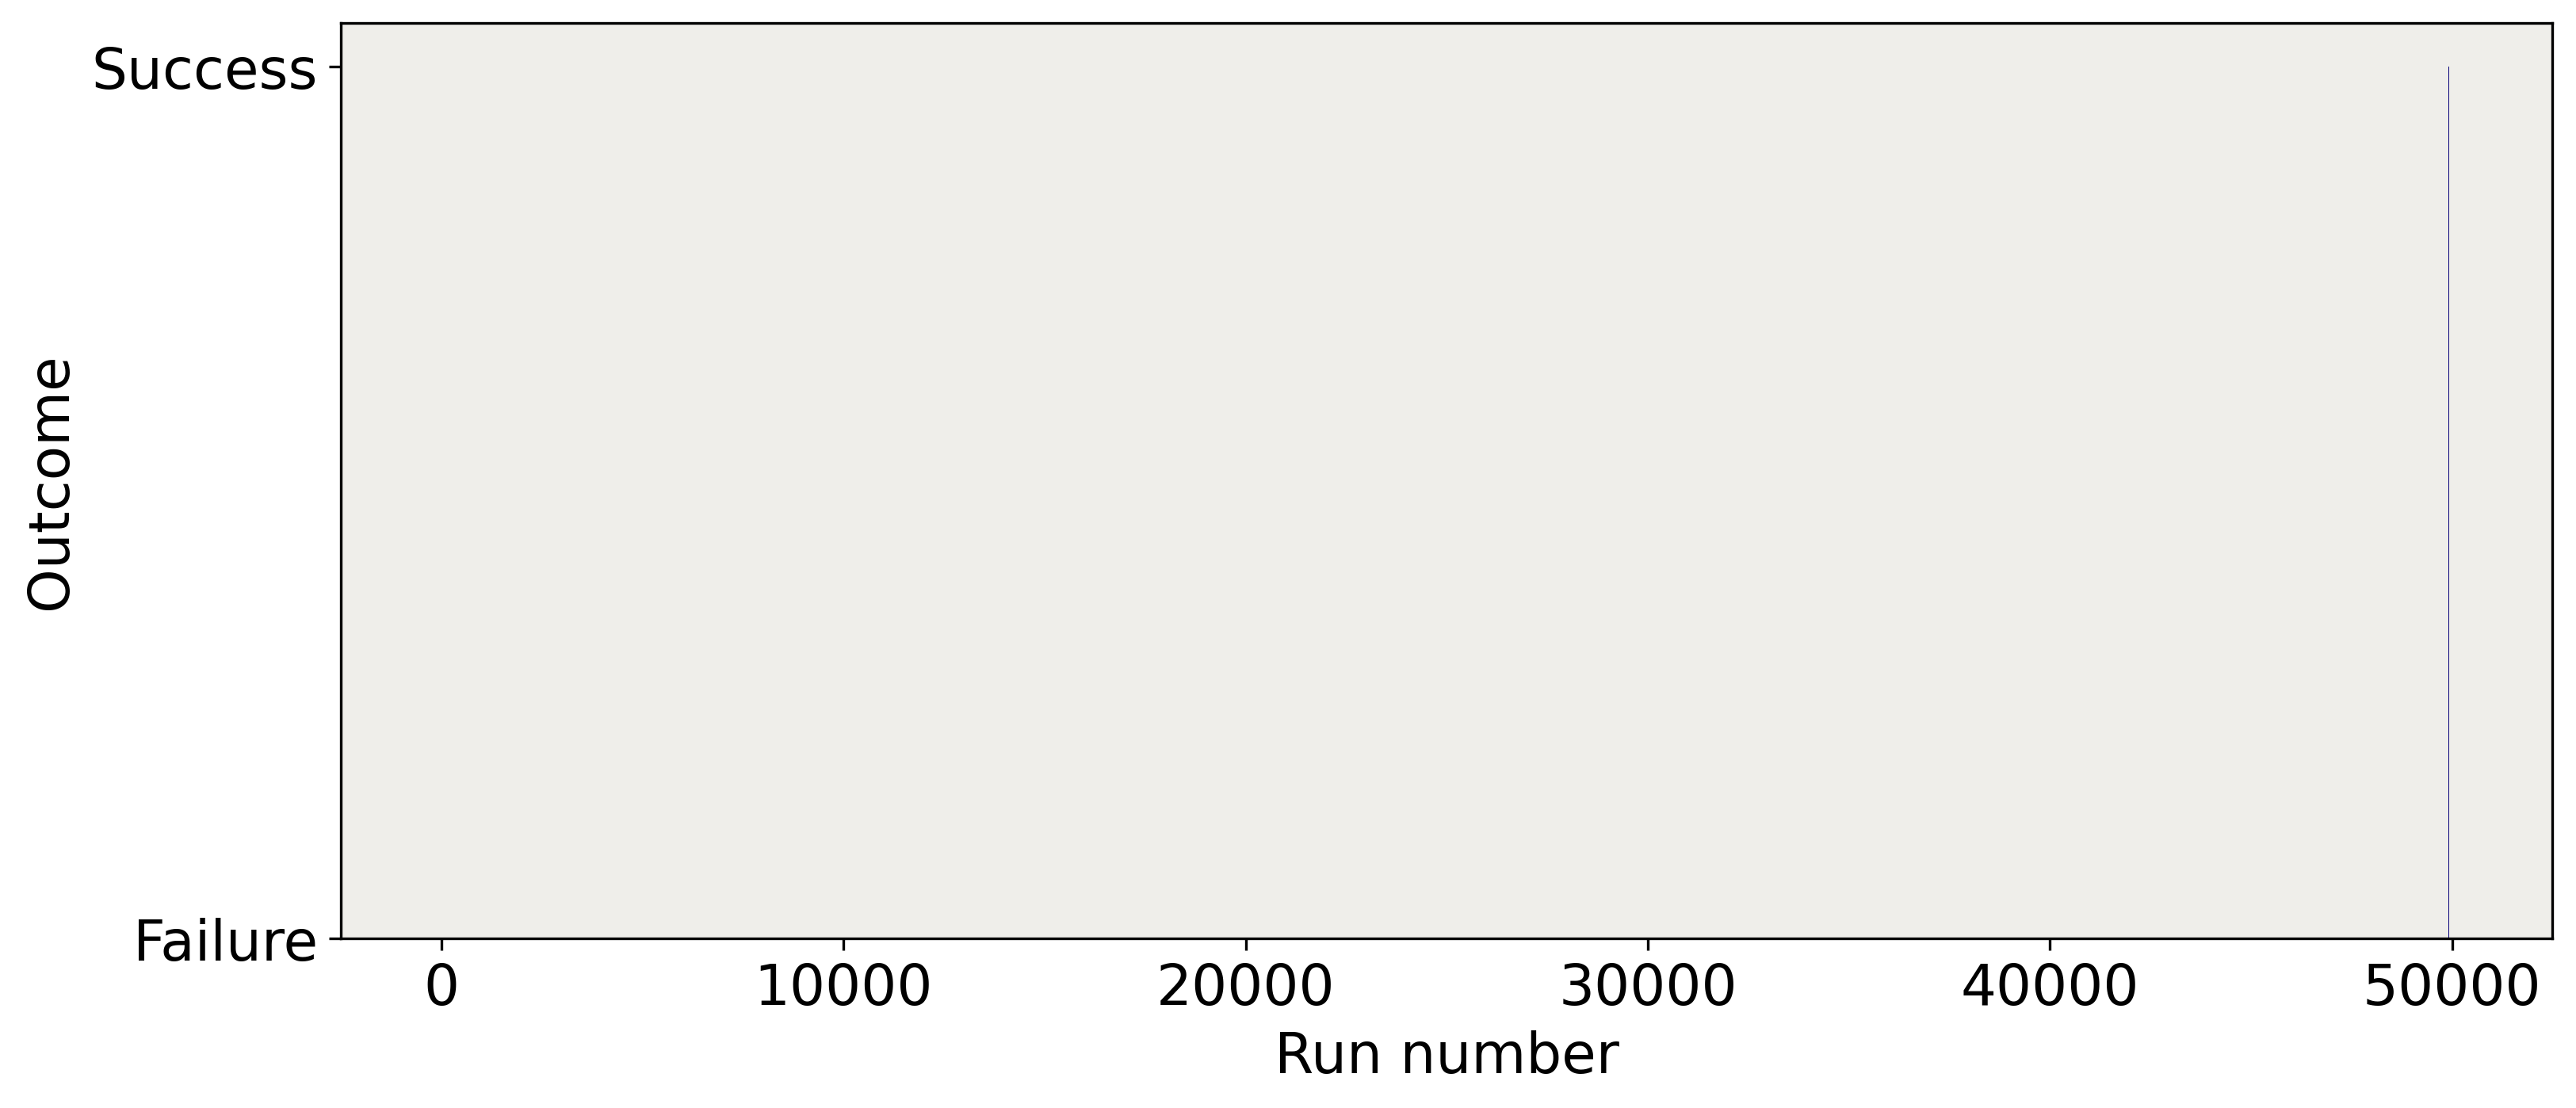

time: 92.797
alpha:  0.01 gamma:  0.01
reward 34322.0


<ipython-input-260-9d17998427cb>:78: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  qo2 = qo2.append(qo)


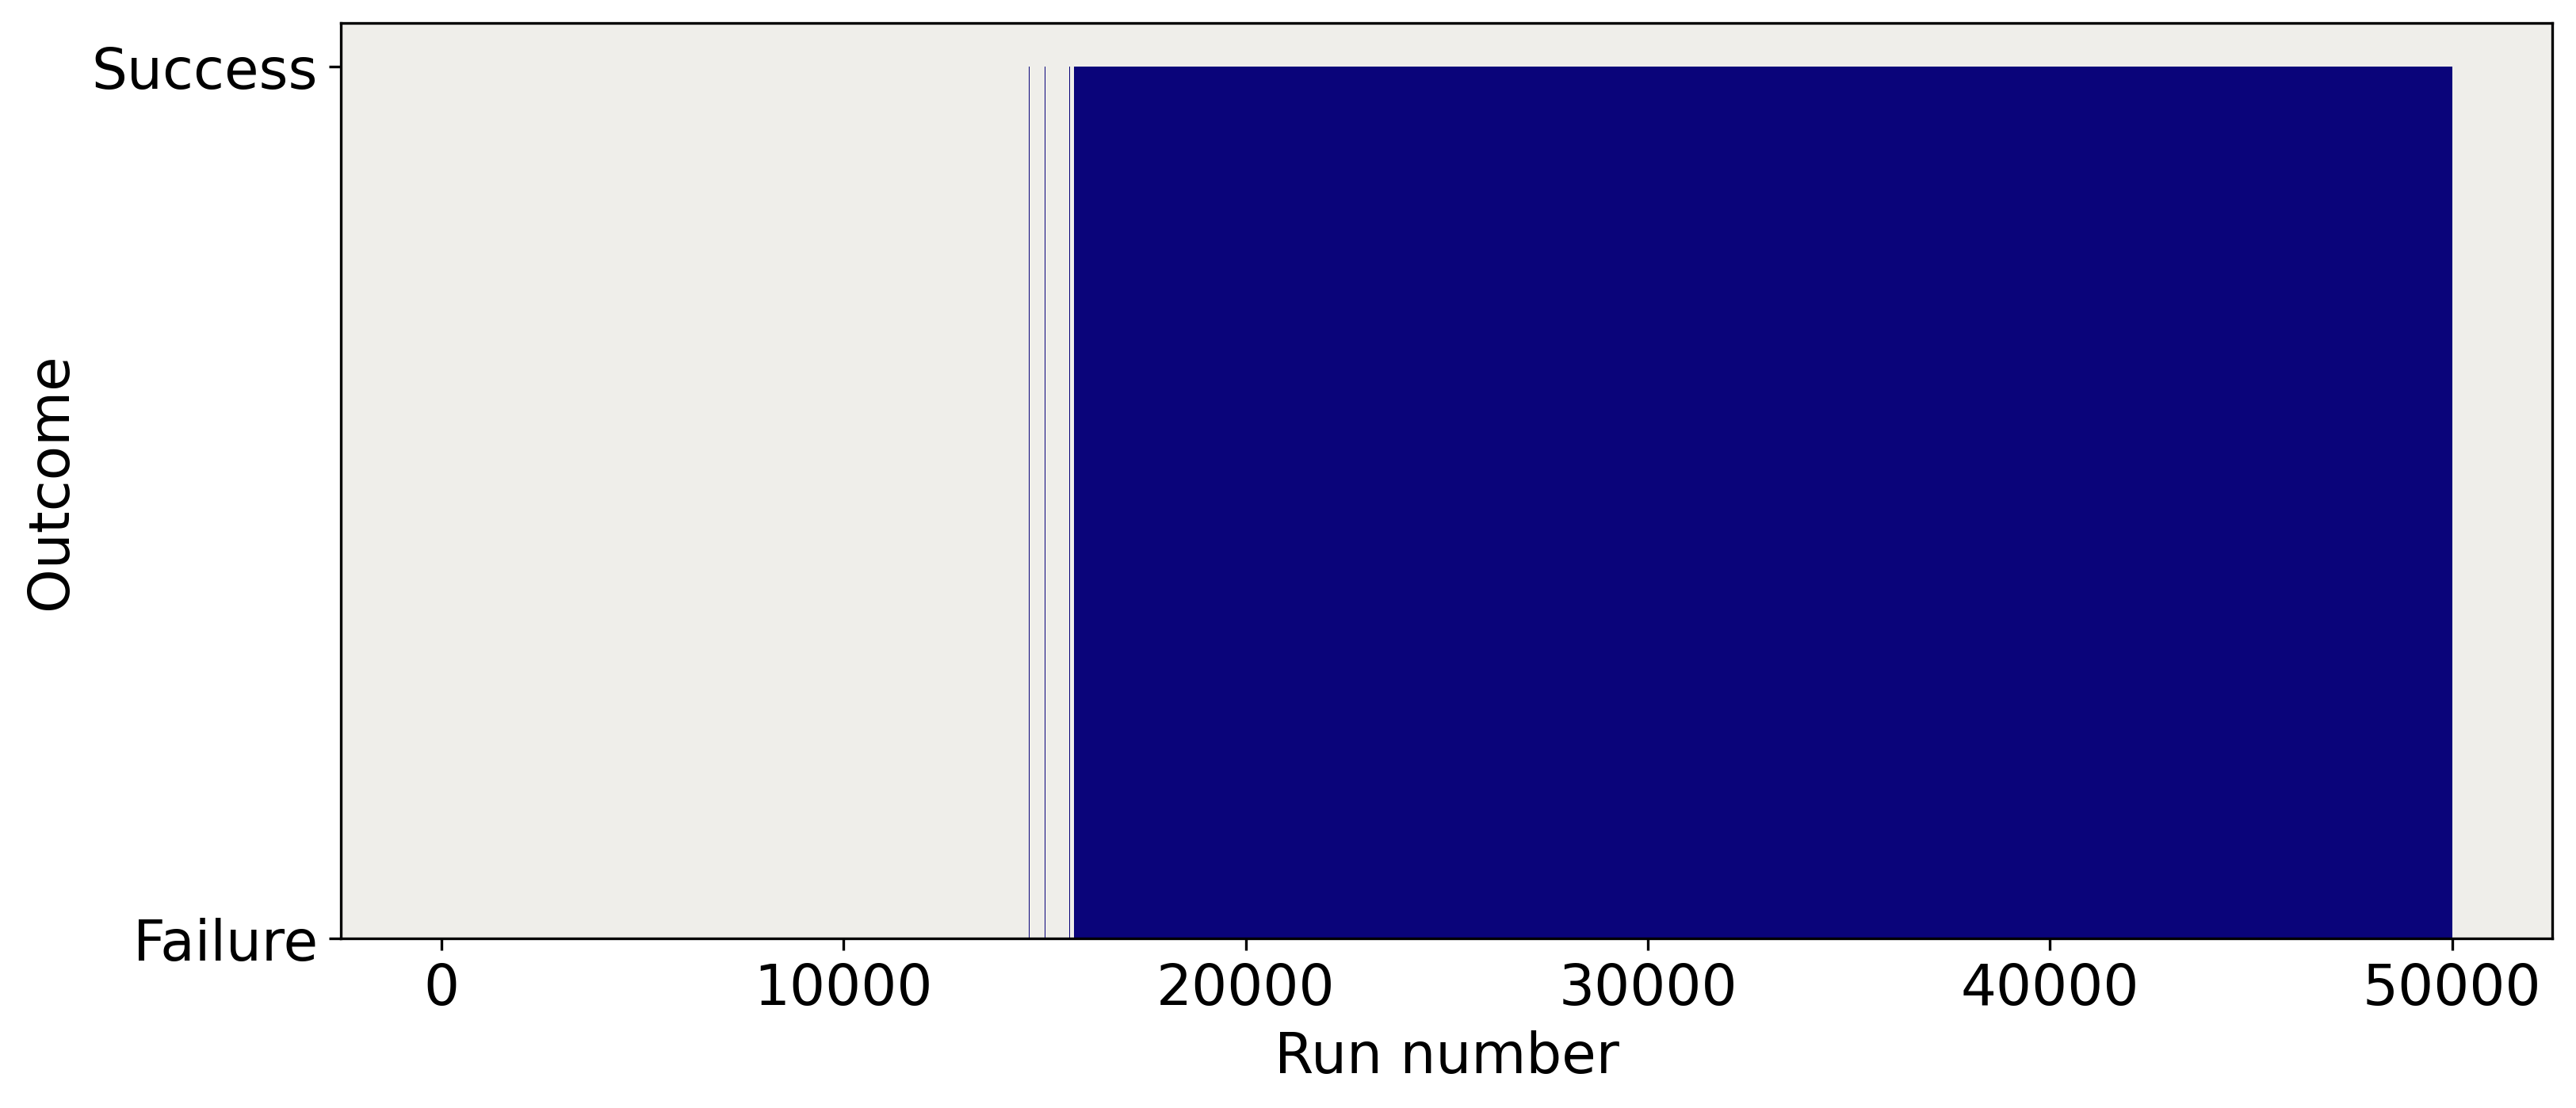

,gamma,learning rate,time,reward
0,0.90,0.90,139.245,8082.0
0,0.50,0.90,93.286,32811.0
0,0.01,0.90,125.827,8767.0
0,0.90,0.50,112.739,22410.0
0,0.50,0.50,111.530,16966.0
0,0.01,0.50,138.542,3.0
0,0.90,0.01,115.314,14407.0
0,0.50,0.01,133.810,9.0
0,0.01,0.01,92.797,34322.0


,gamma,learning rate,time,reward
0,0.01,0.90,125.827,8767.0
0,0.01,0.50,138.542,3.0
0,0.01,0.01,92.797,34322.0
0,0.50,0.90,93.286,32811.0
0,0.50,0.50,111.530,16966.0
0,0.50,0.01,133.810,9.0
0,0.90,0.90,139.245,8082.0
0,0.90,0.50,112.739,22410.0
0,0.90,0.01,115.314,14407.0


In [260]:
import matplotlib.pyplot as plt
qo2 = pd.DataFrame()
random_map = generate_random_map(size=16, p=0.95)
env_name  = 'FrozenLake'
environment = gym.make(env_name, desc=random_map, is_slippery=False)
for alpha in [0.9, 0.5, 0.01]:
  for gamma in [0.9, 0.5, 0.01]:  
    
    environment.reset()
    # environment.render()


    # plt.rcParams['figure.dpi'] = 300
    # plt.rcParams.update({'font.size': 17})

    # We re-initialize the Q-table
    qtable = np.zeros((environment.observation_space.n, environment.action_space.n))

    # Hyperparameters
    episodes = 50000        # Total number of episodes
    # alpha = 0.5            # Learning rate
    # gamma = 0.9            # Discount factor

    # List of outcomes to plot
    outcomes = []
    rew = []

    # print('Q-table before training:')
    # print(qtable)

    # Training
    start = time.time()
    for _ in range(episodes):
        state = environment.reset()
        done = False

        # By default, we consider our outcome to be a failure
        outcomes.append("Failure")

        # Until the agent gets stuck in a hole or reaches the goal, keep training it
        while not done:
            # Choose the action with the highest value in the current state
            if np.max(qtable[state]) > 0:
              action = np.argmax(qtable[state])

            # If there's no best action (only zeros), take a random one
            else:
              action = environment.action_space.sample()
                
            # Implement this action and move the agent in the desired direction
            new_state, reward, done, info = environment.step(action)

            # Update Q(s,a)
            qtable[state, action] = qtable[state, action] + \
                                    alpha * (reward + gamma * np.max(qtable[new_state]) - qtable[state, action])
            
            # Update our current state
            state = new_state
            rew.append(reward)

            # If we have a reward, it means that our outcome is a success
            if reward:
              outcomes[-1] = "Success"

    print('===========================================')
    end = time.time()-start
    print('time:', np.round(end,3))
    print('alpha: ', alpha, 'gamma: ', gamma)
    print('reward', np.sum(rew))
    # print('Q-table after training:')
    # print(qtable)
    qo = pd.DataFrame({
        'gamma':[gamma],
        'learning rate':[alpha],
        'time': [np.round(end,3)],
        'reward': [np.sum(rew)]
    })
    qo2 = qo2.append(qo)

    # Plot outcomes
    plt.figure(figsize=(12, 5))
    plt.xlabel("Run number")
    plt.ylabel("Outcome")
    ax = plt.gca()
    ax.set_facecolor('#efeeea')
    plt.bar(range(len(outcomes)), outcomes, color="#0A047A", width=1.0)
    plt.show()

display(qo2)
display(qo2.sort_values('gamma'))